# Exploration du jeu de données

Dans ce notebook, nous réalisons une exploration du jeu de données pour se dresser une meilleur compréhension du jeu de données.

Nous réalisons des analyse univarités et multivariée succinte pour étudier les facteurs influançant le temps d'interventions des forces de secours.

In [1]:
import pandas as pd
import scipy as sp
import os
import numpy as np
import pprint
import seaborn as sns
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

In [2]:
# Adapt to load code
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.path.realpath(".")), "code"))
%load_ext autoreload
%autoreload 2

# Home-made helpers functions
from settings import TRAINING_DATA, TRAFFIC_DATA, DATA_FOLDER, INDEX_COLUMN, alert_reason_category_name
from interfaces import plot_on_map, show_itinary, ClickableMap, get_itinary

Using TensorFlow backend.


In [3]:
# make /comfy/ notebook 
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (30, 10)
sns.set(color_codes=True)

In [4]:
x_train = pd.read_csv(os.path.join(TRAINING_DATA, 'x_train.csv'), sep=',', index_col=INDEX_COLUMN)
y_train = pd.read_csv(os.path.join(TRAINING_DATA, 'y_train.csv'), sep=',', index_col=INDEX_COLUMN)

## Inspection des temps de réponses

In [5]:
y_train.describe()

delta selection-departure  delta departure-presentation  \
count              219337.000000                 219337.000000   
mean                  138.771808                    356.161026   
std                    77.710577                    228.381939   
min                     0.000000                      1.000000   
25%                   100.000000                    231.000000   
50%                   131.000000                    319.000000   
75%                   168.000000                    434.000000   
max                 17758.000000                  22722.000000   

       delta selection-presentation  
count                 219337.000000  
mean                     494.932834  
std                      243.194825  
min                        4.000000  
25%                      363.000000  
50%                      458.000000  
75%                      581.000000  
max                    22934.000000

Confirmation que les deux deltas s'additionnent.

In [6]:
np.mean(y_train["delta selection-departure"] + y_train["delta departure-presentation"] == y_train["delta selection-presentation"])

1.0

In [7]:
delta_sd = np.array(y_train["delta selection-departure"])
delta_dp = np.array(y_train["delta departure-presentation"])

## Étude de la distribution des temps de préparation et de transit

On s'intéresse à la queue des distributions.

In [8]:
np.mean(delta_dp > 2000), np.mean(delta_sd > 2000)

(0.0011443577690950456, 5.471033159020138e-05)

Celles-ci sont relativement petites : on ne les prend pas en compte dans l'étude de la distribution si dessous car il s'agit d'outliers dans les données (oublis de l'enlanchement manuel du signal d'arrivée).

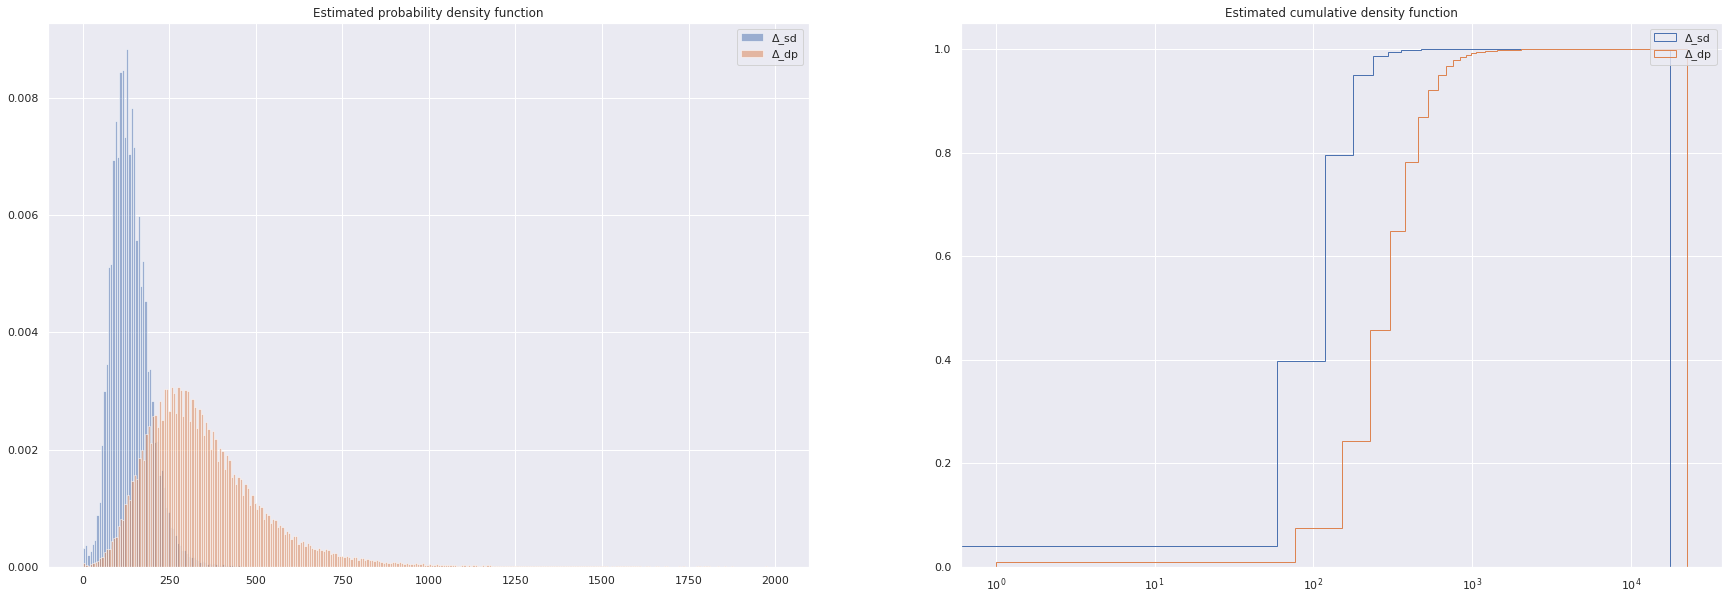

In [9]:
plt.subplot(1,2,1)

plt.hist(delta_sd[delta_sd < 2000], bins=300, density=True, alpha=0.5, label='Δ_sd');
plt.hist(delta_dp[delta_dp < 2000], bins=300, density=True, alpha=0.5, label='Δ_dp');

plt.title("Estimated probability density function")

plt.legend()

plt.subplot(1,2,2)

plt.hist(delta_sd, bins=300, density=True, cumulative=True, label='Δ_sd', 
         histtype='step') ;

plt.hist(delta_dp, bins=300, density=True, cumulative=True, label='Δ_dp', 
         histtype='step') ;

plt.title("Estimated cumulative density function")
plt.xscale("log")
plt.legend()

## Inspection des interventions

In [10]:
x_train.keys()

Index(['intervention', 'alert reason category', 'alert reason',
       'intervention on public roads', 'floor', 'location of the event',
       'longitude intervention', 'latitude intervention', 'emergency vehicle',
       'emergency vehicle type', 'rescue center', 'selection time',
       'date key sélection', 'time key sélection',
       'status preceding selection',
       'delta status preceding selection-selection',
       'departed from its rescue center', 'longitude before departure',
       'latitude before departure',
       'delta position gps previous departure-departure',
       'GPS tracks departure-presentation',
       'GPS tracks datetime departure-presentation', 'OSRM response',
       'OSRM estimated distance', 'OSRM estimated duration'],
      dtype='object')

In [11]:
n, d = x_train.shape

## Sous-échantillonnage pour inspection simplifiée

On s'intéresse à la localisation des interventions.

In [12]:
np.random.seed(1337)
samples = np.random.choice(n, 100, replace=False)
x_samples = x_train.iloc[samples]

In [13]:
lons_samples = np.array(x_samples["longitude intervention"])
lats_samples = np.array(x_samples["latitude intervention"])

lon_mean = np.mean(lons_samples)
lat_mean = np.mean(lats_samples)

In [14]:
m = plot_on_map(lons_samples,lats_samples)
display(m)

ClickableMap(center=[48.85228781000001, 2.3783365499999998], controls=(ZoomControl(options=['position', 'zoom_…

### 2-D Kernel density estimations  

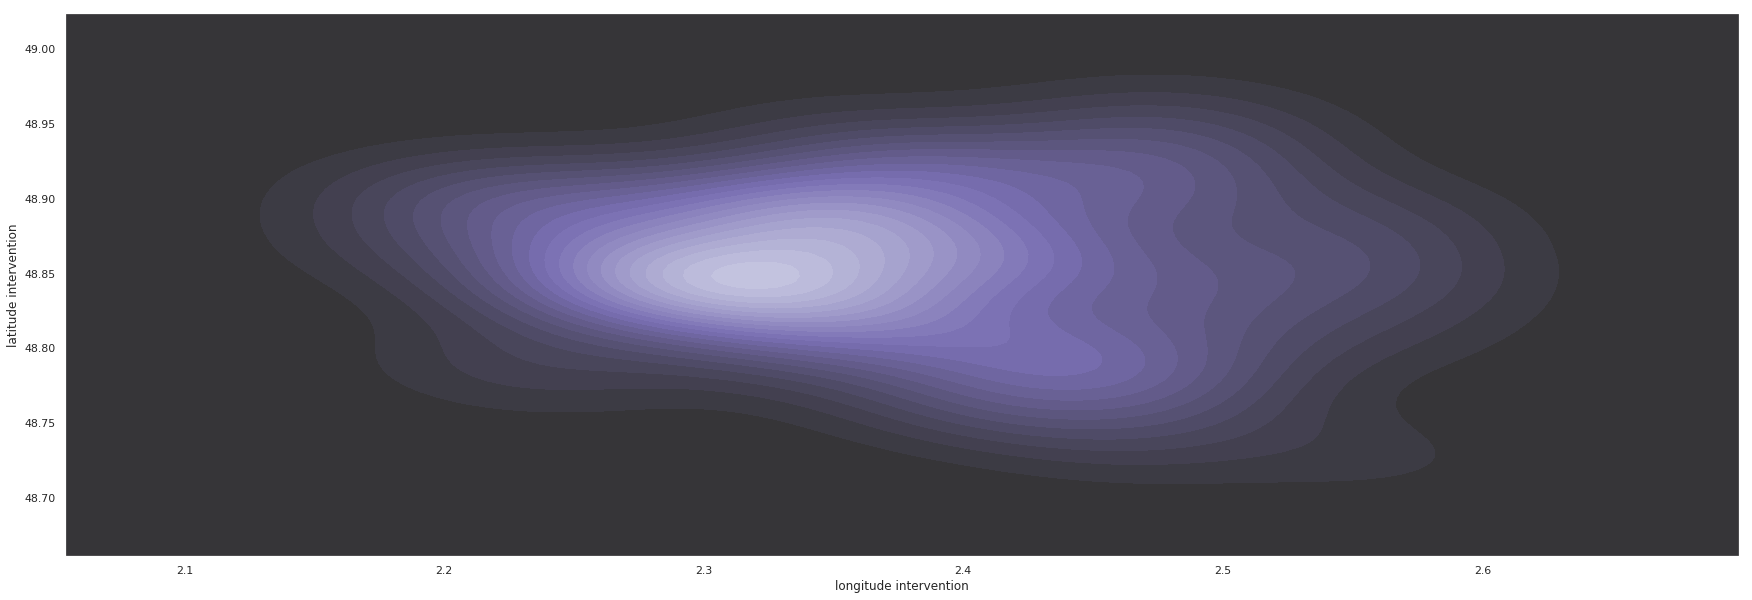

In [15]:
ax = sns.kdeplot(x_samples["longitude intervention"], x_samples["latitude intervention"], n_levels=30, shade=True, cmap="Purples_d")

Les interventions sont le plus souvent situées dans Paris intramuros.

In [16]:
x_samples.head()

intervention  alert reason category  \
emergency vehicle selection                                        
5290337                          13564085                      3   
5097651                          13252185                      3   
5070125                          13210879                      3   
4980659                          13069413                      3   
4730924                          12679499                      3   

                             alert reason  intervention on public roads  \
emergency vehicle selection                                               
5290337                              2163                             0   
5097651                              2112                             0   
5070125                              2118                             0   
4980659                              2112                             0   
4730924                              2112                             0   

                             floor  location of the event  \
emergency vehicle selection                                 
5290337                          8                  139.0   
5097651                          0                  139.0   
5070125                          0                  139.0   
4980659                          0                  106.0   
4730924                          0                  104.0   

                             longitude intervention  latitude intervention  \
emergency vehicle selection                                                  
5290337                                    2.317176              48.819785   
5097651                                    2.479995              48.790594   
5070125                                    2.429159              48.785765   
4980659                                    2.333835              48.850376   
4730924                                    2.267685              48.842017   

                             emergency vehicle emergency vehicle type  \
emergency vehicle selection                                             
5290337                                   1901                    PSE   
5097651                                   5783              VSAV BSPP   
5070125                                   2100              VSAV BSPP   
4980659                                   4543              VSAV BSPP   
4730924                                   4509              VSAV BSPP   

                                      ...             \
emergency vehicle selection           ...              
5290337                               ...              
5097651                               ...              
5070125                               ...              
4980659                               ...              
4730924                               ...              

                             delta status preceding selection-selection  \
emergency vehicle selection                                               
5290337                                                           41933   
5097651                                                              82   
5070125                                                            4911   
4980659                                                             894   
4730924                                                             134   

                            departed from its rescue center  \
emergency vehicle selection                                   
5290337                                                   1   
5097651                                                   1   
5070125                                                   1   
4980659                                                   1   
4730924                                                   1   

                             longitude before departure  \
emergency vehicle selection                               
5290337                                        2.290318   
5

On peut regarder l'exemple d'un intervention et l'itinéraire recommandé pour y arriver.

In [17]:
example = dict(x_samples.iloc[0])
lon_start, lat_start = example["longitude before departure"], example["latitude before departure"]
lon_end, lat_end = example["longitude intervention"], example["latitude intervention"]

In [18]:
show_itinary(lon_start, lat_start, lon_end, lat_end)

# Analyse univariée

On dresse ici quelques éléments d'étude univariée de certains descripteurs pour juger de leur pertinence dans l'étude.

## Analyse de l'alerte (`alert reason category`, `alert reason`)

In [19]:
def histo(col):
    """
    Plot histogram for a categorical column named col
    
    @param col: Pandas Series
    """
    counts = dict(col.value_counts().sort_index())
    indices = list(counts.keys())
    values = list(counts.values())
    chart = sns.barplot(x=indices, y=values)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90) ; 
    chart.set_title(f"{col.name} occurences") ; 

In [20]:
alert_reason_category = np.array(x_train["alert reason category"])

In [21]:
sorted(x_train["alert reason category"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9]

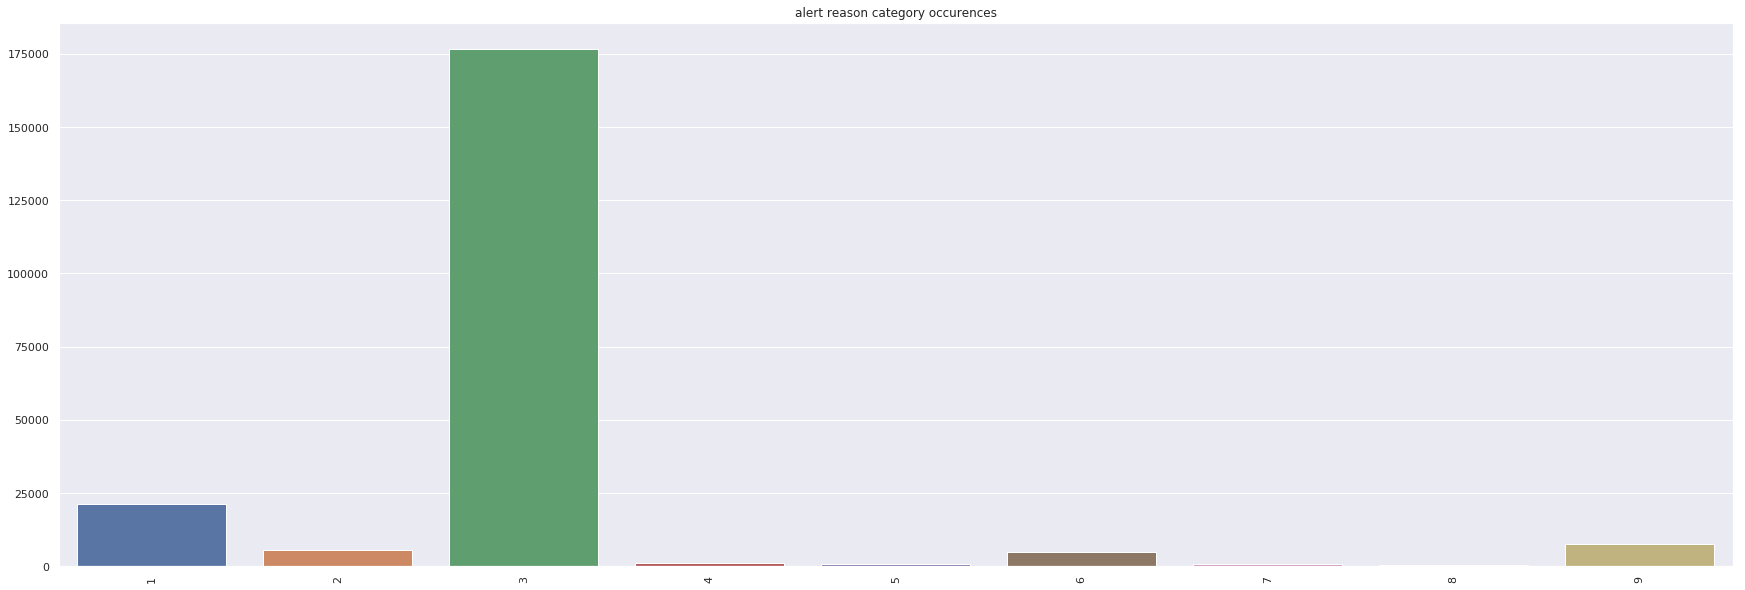

In [22]:
histo(x_train["alert reason category"])

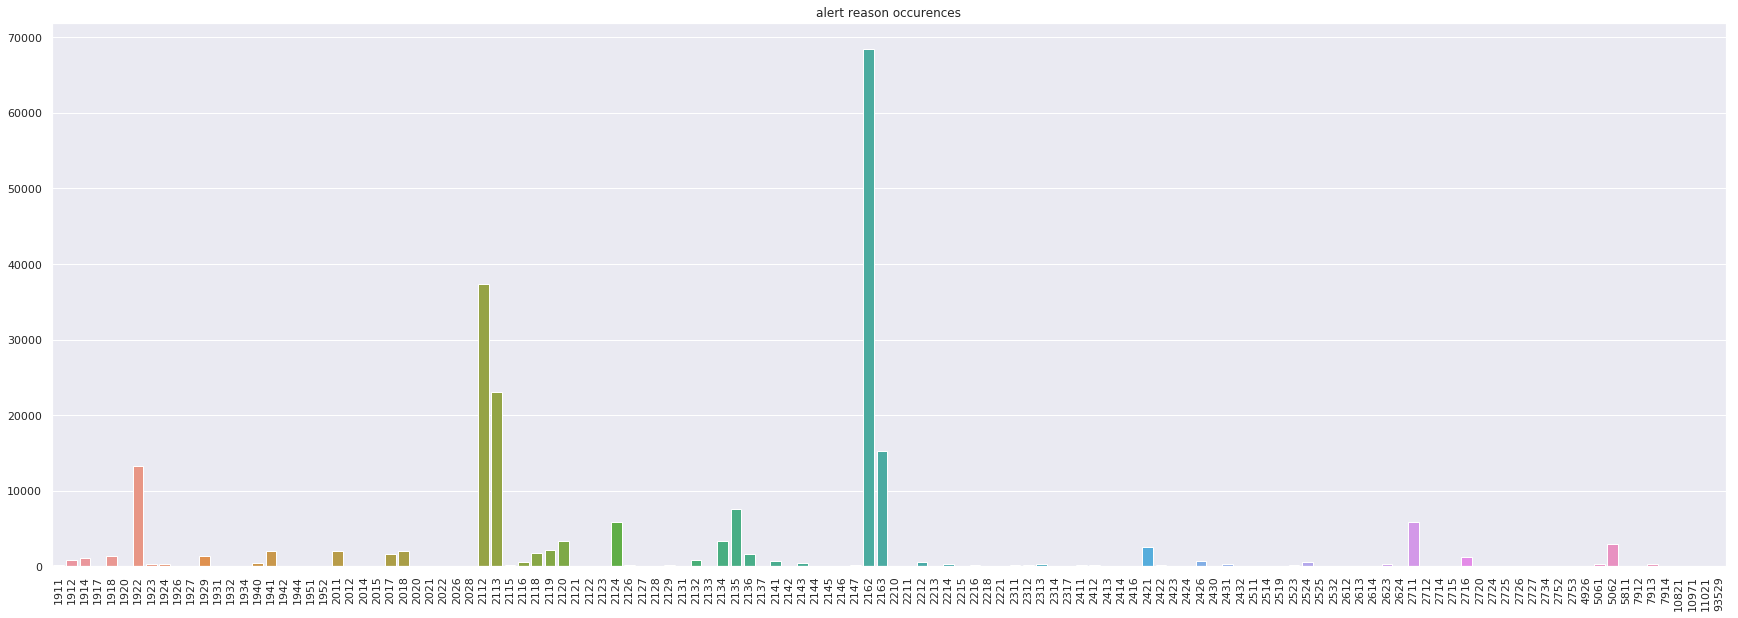

In [23]:
histo(x_train["alert reason"])

## Étage

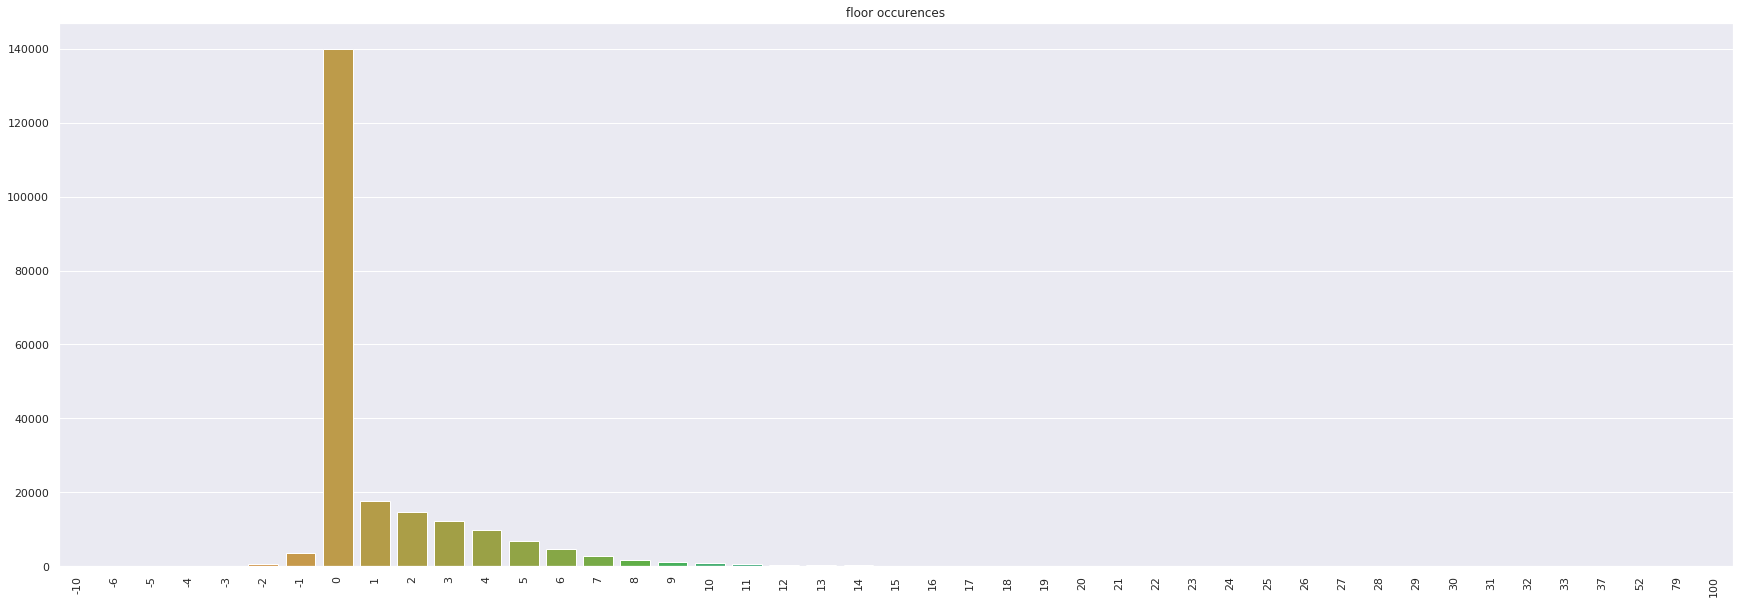

In [24]:
histo(x_train["floor"])

## Lieu de l'évènement (`location of the event`)

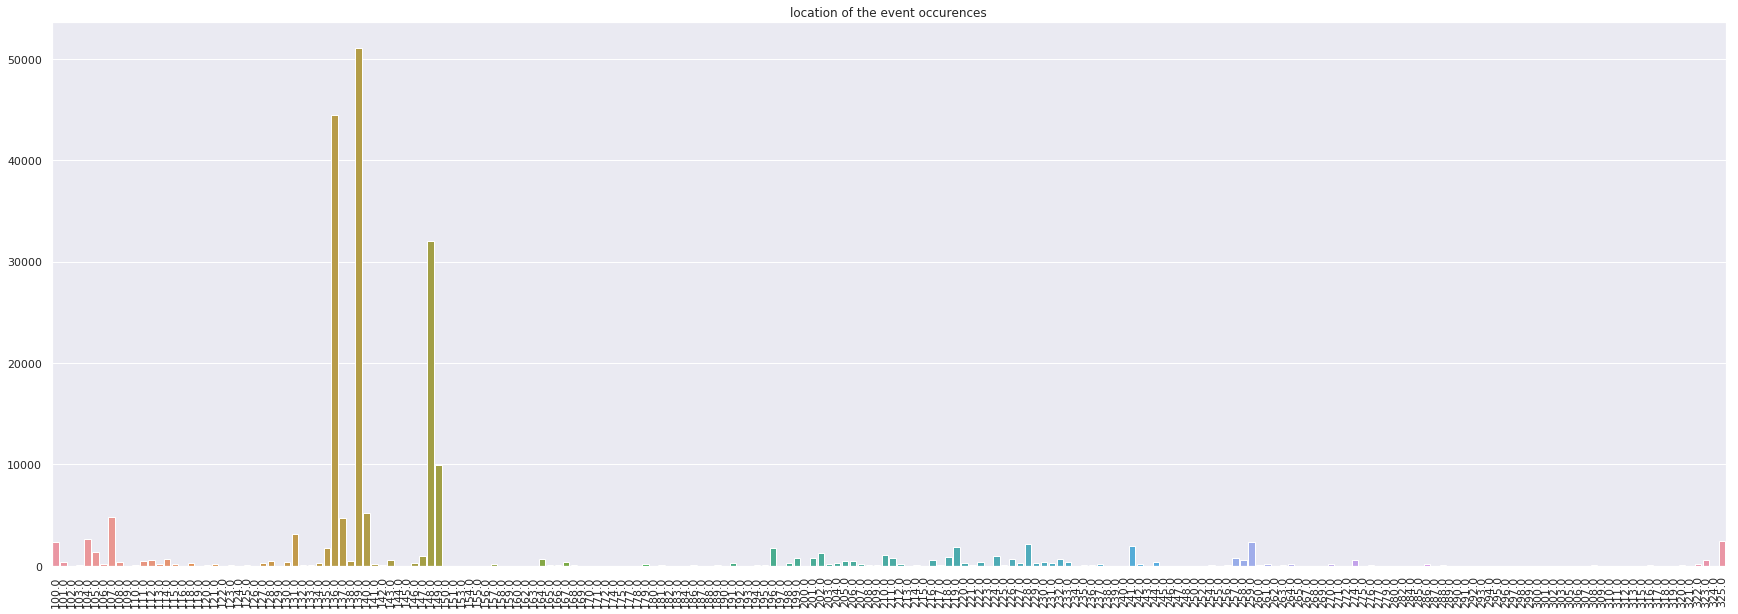

In [25]:
histo(x_train["location of the event"])

### Fractions des valeurs manquantes

In [26]:
x_train["location of the event"].isnull().mean()

0.057947359542621625

## Véhicule de secours (`emergency vehicle` et `emergency vehicle type`)

### Véhicule

In [27]:
len(x_train["emergency vehicle"].unique())

749

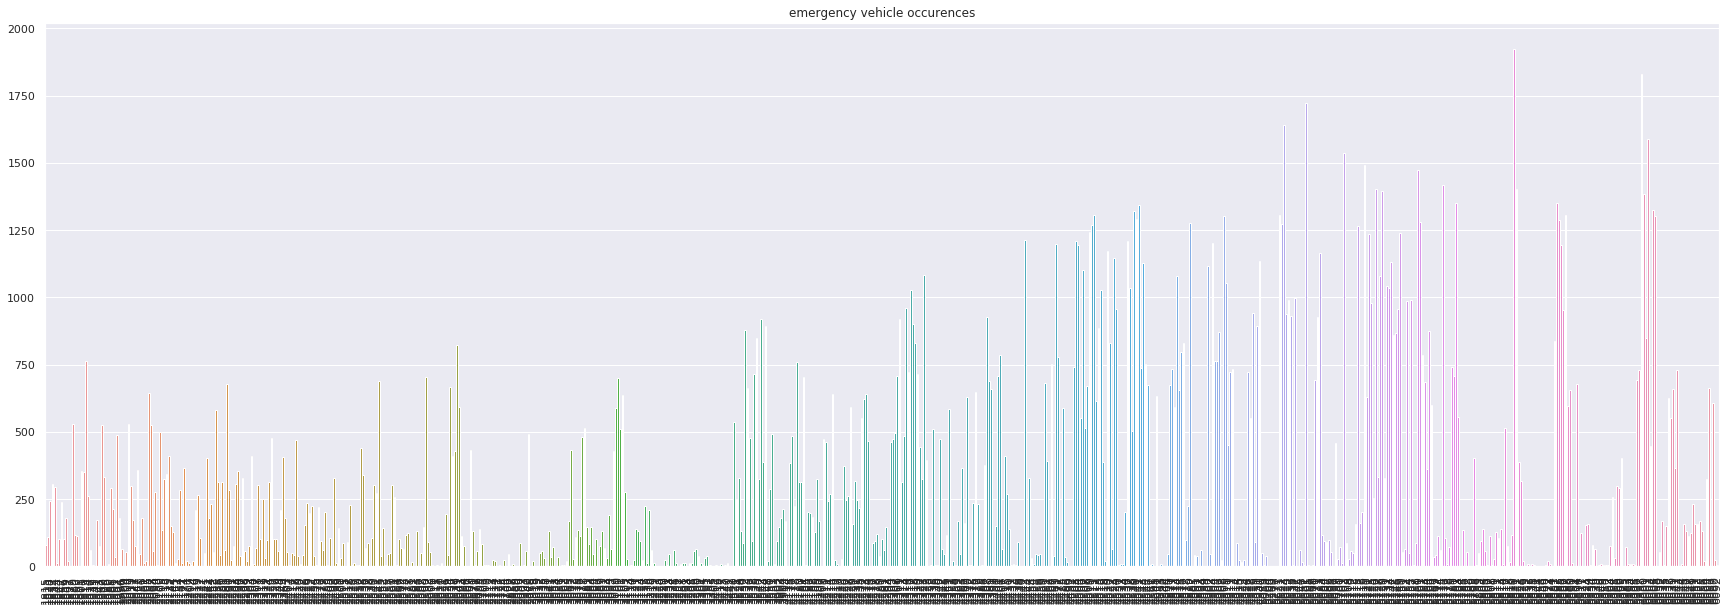

In [28]:
histo(x_train["emergency vehicle"])

In [29]:
len(x_train["emergency vehicle type"].unique())

75

### Type véhicule

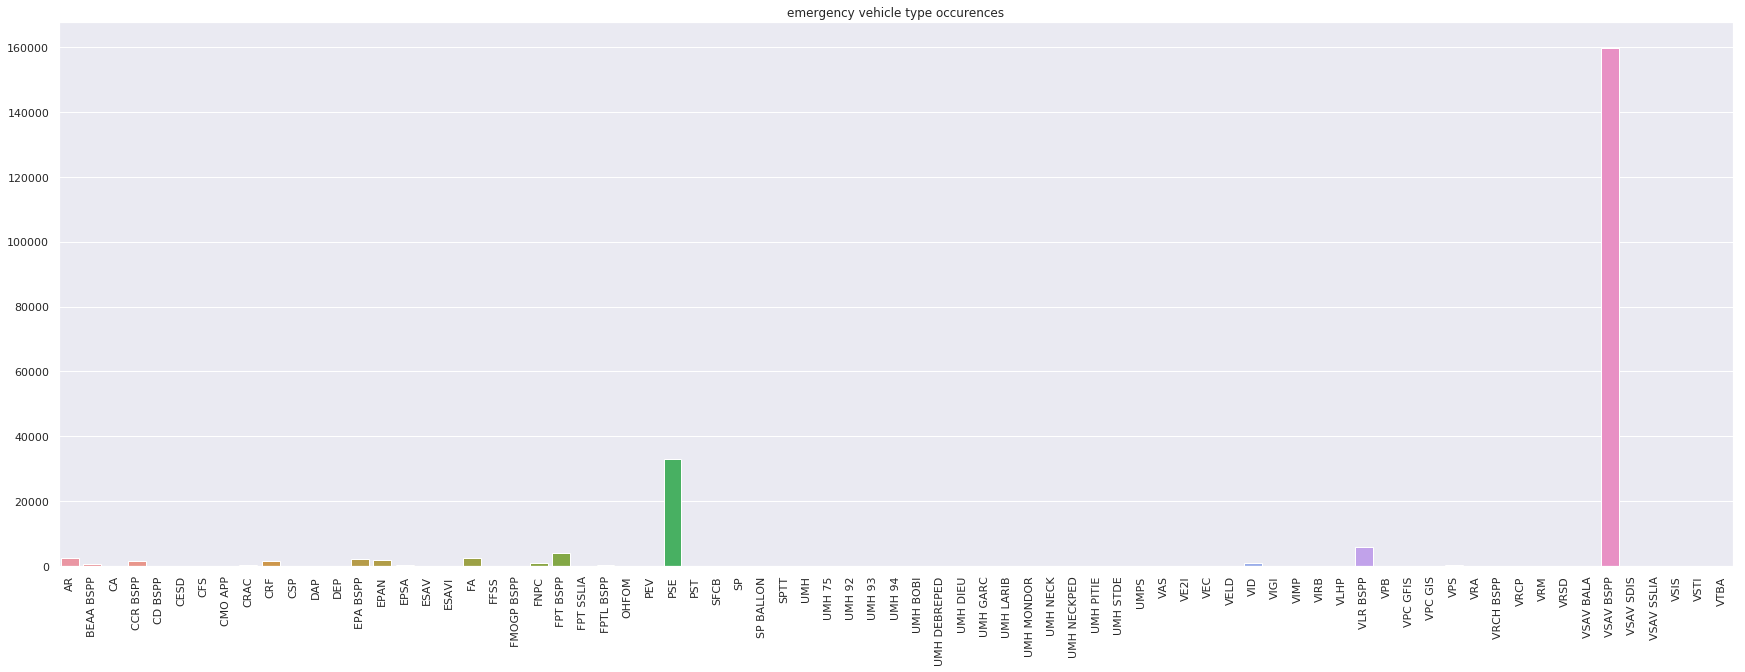

In [30]:
histo(x_train["emergency vehicle type"])

## Études des centres de secours / casernes

Généralement les véhicules partent de leur centre de secours

In [31]:
x_train["departed from its rescue center"].mean()

0.9776462703511035

On s'intéresse dans la suite aux zones de départ des équipes de secours. 

In [32]:
lats_bd = np.array(x_train[x_train['departed from its rescue center'] == 1]["latitude before departure"])
lons_bd = np.array(x_train[x_train['departed from its rescue center'] == 1]["longitude before departure"])

In [33]:
len(np.unique(lats_bd)), len(np.unique(lons_bd))

(88, 88)

## Casernes de Pompiers de Paris

Les données sur les centres de secours peuvent être récupérées en ligne [ici](https://www.data.gouv.fr/en/datasets/liste-des-casernes-a-paris-et-dans-les-departements-de-la-petite-couronne-551678/).
Pour extraire les coordonnées des casernes de pompiers:

```bash
$  more Bspp.kml | grep coord | sed -e 's/<[^>]*>//g' | sed  "s/ //g" > casernes_coords.csv
```

In [34]:
centre_secours = pd.read_csv(os.path.join(DATA_FOLDER, "centre_secours.csv"), delimiter=",")
centre_secours

id           denomination  groupement  CIE       tel_ville  \
0   MONN             LA MONNAIE           3    4  01 43 54 64 36   
1   BLAN                BLANCHE           1    7  01 40 23 20 28   
2   TREM     TREMBLAY-EN-FRANCE           1   13  01 48 60 61 10   
3   LIVR           LIVRY-GARGAN           1   14  01 43 83 58 26   
4   CLIC       CLICHY-SOUS-BOIS           1   14  01 45 09 40 10   
5   NEUI      NEUILLY-SUR-MARNE           1   24  01 43 08 14 34   
6   MTRL              MONTREUIL           1   24  01 42 87 20 31   
7   BOND                  BONDY           1   14  01 41 55 54 28   
8   PIER            PIERREFITTE           1   26  01 49 71 54 08   
9   AULN       AULNAY-SOUS-BOIS           1   13  01 43 83 53 33   
10  BLME            BLANC MENIL           1   13  01 48 67 42 89   
11  DRAN                 DRANCY           1   13  01 48 32 02 64   
12  LACO           LA COURNEUVE           1   26  01 48 36 32 64   
13  PANT                 PANTIN           1   10  01 48 45 60 41   
14  AUBE          AUBERVILLIERS           1   26  01 48 33 72 11   
15  STDE            SAINT DENIS           1   26  01 48 13 85 28   
16  STOU             SAINT OUEN           1    9  01 41 66 49 28   
17  GENN          GENNEVILLIERS           3   27  01 47 94 18 14   
18  ASNI               ASNIERES           3   27  01 47 99 71 19   
19  COBE               COLOMBES           3   27  01 42 42 00 63   
20  MALA                  MALAR           3    4  01 45 55 08 81   
21  BITC                 BITCHE           1   10  01 44 65 94 48   
22  LAND                 LANDON           1   10  01 40 35 58 31   
23  MTMA             MONTMARTRE           1    9  01 42 26 83 28   
24  BSLT              BOURSAULT           1    9  01 45 22 43 13   
25  DAUP               DAUPHINE           3    5  01 45 53 84 68   
26  AUTE                AUTEUIL           3    6  01 42 88 76 20   
27  MENI           MENILMONTANT           1   12  01 40 31 44 18   
28  CHAR               CHARONNE           1   12  01 43 71 51 22   
29  PARM             PARMENTIER           1   11  01 43 57 27 43   
..   ...                    ...         ...  ...             ...   
46  STCL            SAINT CLOUD           3   16  01 55 39 39 28   
47  SEVR                 SEVRES           3   16  01 45 34 05 79   
48  MEUD                 MEUDON           3   16  01 45 34 02 86   
49  BOUL               BOULOGNE           3   16  01 46 21 01 15   
50  ISSY    ISSY-LES-MOULINEAUX           3    6  01 46 42 04 04   
51  CLAM                CLAMART           3   21  01 41 09 75 28   
52  PLCL        PLESSIS-CLAMART           3   21  01 46 32 06 76   
53  MTGE              MONTROUGE           3    3  01 58 07 05 28   
54  BGLR         BOURG-LA-REINE           3   21  01 46 63 09 48   
55  ANTO                 ANTONY           3   21  01 46 66 09 90   
56  VIMB            VILLEMOMBLE           1   24  01 45 28 73 06   
57  NOIS         NOISY-LE-GRAND           2   15  01 43 04 22 10   
58  IVRY                   IVRY           2    2  01 46 72 64 34   
59  NATI               NATIVITE           2    1  01 43 43 54 65   
60  MASS                MASSENA           2    2  01 45 83 82 66   
61  VINC              VINCENNES           2    1  01 58 64 13 28   
62  NOGT       NOGENT-SUR-MARNE           2   15  01 55 85 15 28   
63  CHPY              CHAMPIGNY           2   15  01 48 81 55 45   
64  STMR             SAINT-MAUR           2   23  01 48 83 87 46   
65  JOIN              JOINVILLE           2   17  01 48 83 34 90   
66  MALF          MAISON-ALFORT           2   17  01 43 78 32 04   
67  CRET                CRETEIL           2   17  01 49 80 28 17   
68  VIJF              VILLEJUIF           2   22  01 47 26 18 19   
69  RUNG                 RUNGIS           2   22  01 46 86 90 10   
70  CHOI          CHOISY-LE-ROI           2   22  01 48 52 33 40   
71  VISG  VILLENEUVE-ST-GEORGES           2   17  01 43 89 03 91   
72  VILC           VILLECRESNES           2   23  01 45 98 90 

In [35]:
plot_on_map(centre_secours["longitude"], centre_secours["latitude"])

ClickableMap(center=[48.856564996462886, 2.367320878784804], controls=(ZoomControl(options=['position', 'zoom_…

On affiche maintenant les interventions et les casernes de pompiers associées.

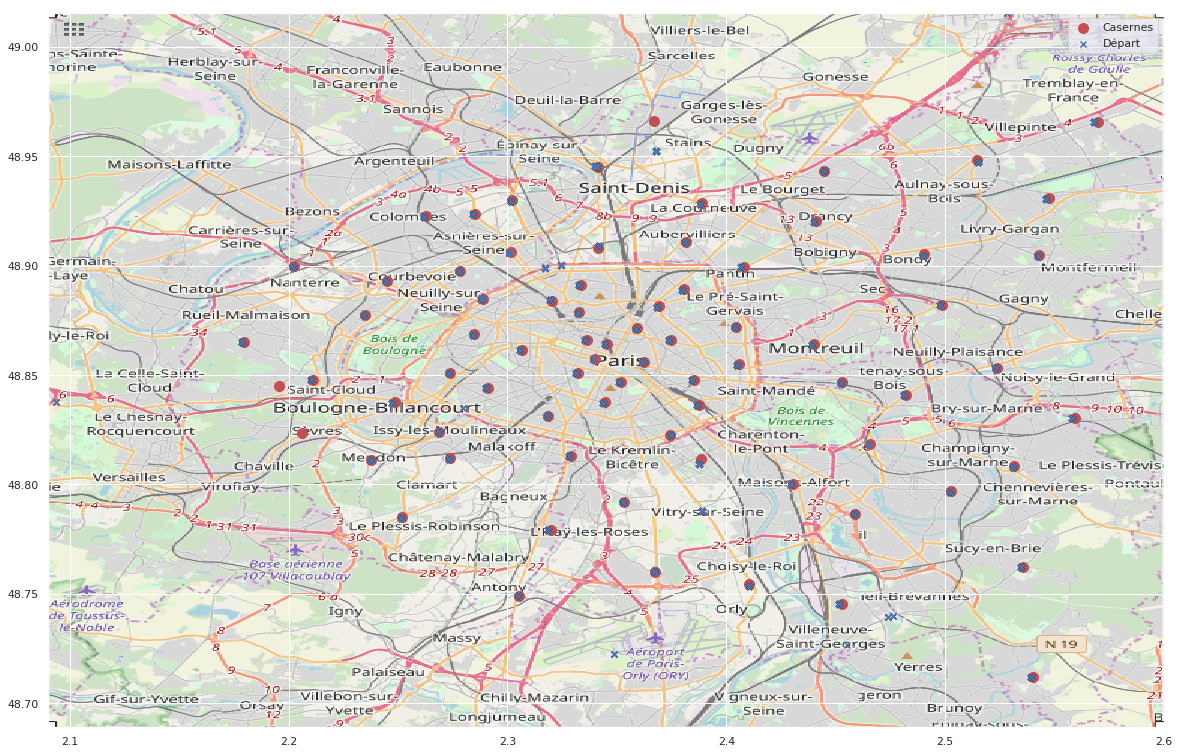

In [36]:
zone = [2.0900, 2.6000, 48.6890, 49.0156]

back_ground = plt.imread("../data/zone.png")

figsize = 20
aspect_ratio = back_ground.shape[0] / back_ground.shape[1]
fig, ax = plt.subplots(figsize = (figsize, figsize * aspect_ratio))

ax.imshow(back_ground, zorder=0, extent = zone, aspect= 'equal')
plt.scatter(centre_secours["longitude"], centre_secours["latitude"], marker="o", c="r", s=100)
plt.scatter(lons_bd, lats_bd, marker="x")
ax.set_xlim(zone[0], zone[1])
ax.set_ylim(zone[2], zone[3])
plt.legend(["Casernes", "Départ"])

## Analyse multivariée

Dans cette partie, on s'intéresse à l'influence des variables catégorielles sur les temps de préparation et d'intervention.

Pour cela on réalise des boîtes à moustaches pour rapidement identifier les variations.

In [37]:
def boxplot(dataset, target_col, by_col, upper_clip, save_path=None):
    """
    Draw a boxplot of a variable wrt to a categorical variable.
    
    :param target_col: the target variable
    :param by_col: the categorical variable
    :param upper_clip: a threshold to filter outliers
    :param save_path: optional, a path to save figure (optional)
    
    """
    plt.figure()
    chart = dataset.boxplot(column=[target_col], by=by_col)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90) ; 
    chart.set_ylabel("(in seconds)")
    chart.set_title(chart.get_title() + f" (cropped at {upper_clip} sec.)")
    plt.ylim((0, upper_clip))
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"{target_col}_by_{by_col}.pdf".replace(" ","_")))
    plt.show()

def add_time_representation(X):
    """
    Add a time representation for the datetime

    :param X: data frame containing a Datetime series named `selection` time
    :return:
    """

    X["selection time"] = pd.to_datetime(X["selection time"])
    dt = X["selection time"].dt

    X["year"] = dt.year
    X["week_of_year"] = dt.weekofyear
    X["month"] = dt.month
    X["day"] = dt.day
    X["day_of_week"] = dt.dayofweek
    X["hour"] = dt.hour
    X["minute"] = dt.minute
    X["second"] = dt.second
    return X


# Jeu join des variables et des temps à prédire
joined = add_time_representation(x_train.join(y_train))
        
categ_vars = [
    'alert reason category',
    'alert reason',
    'intervention on public roads',
    'emergency vehicle type',
    'floor',
    'location of the event',
    'rescue center',
    'status preceding selection',
    'departed from its rescue center',
]

time_vars = ['week_of_year', 'month', 'day_of_week', 'day', 'hour', "minute"]

In [38]:
joined = add_time_representation(x_train).join(y_train)

### Étude du temps de préparation selon les variables temporelles

<Figure size 2160x720 with 0 Axes>

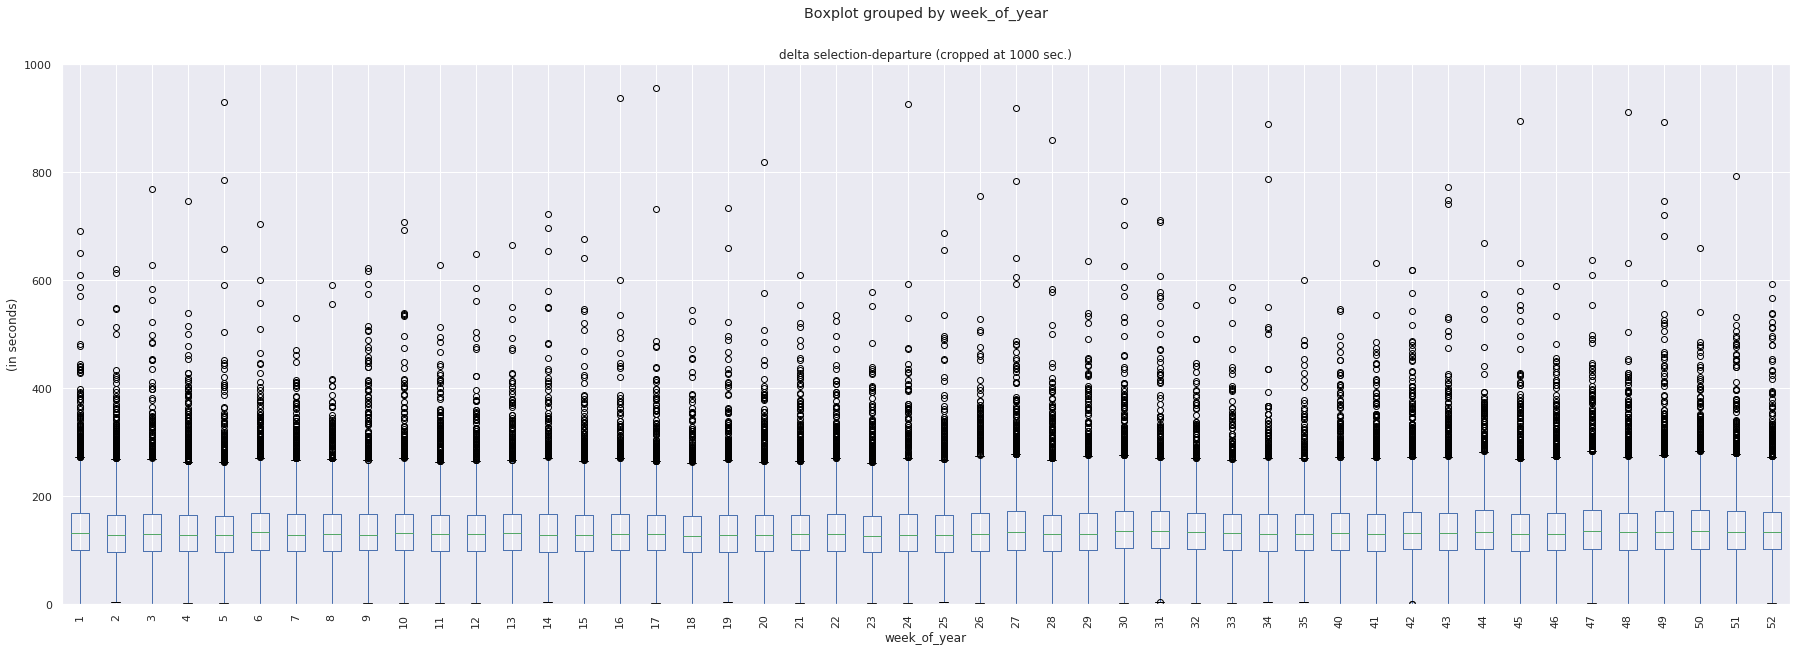

<Figure size 2160x720 with 0 Axes>

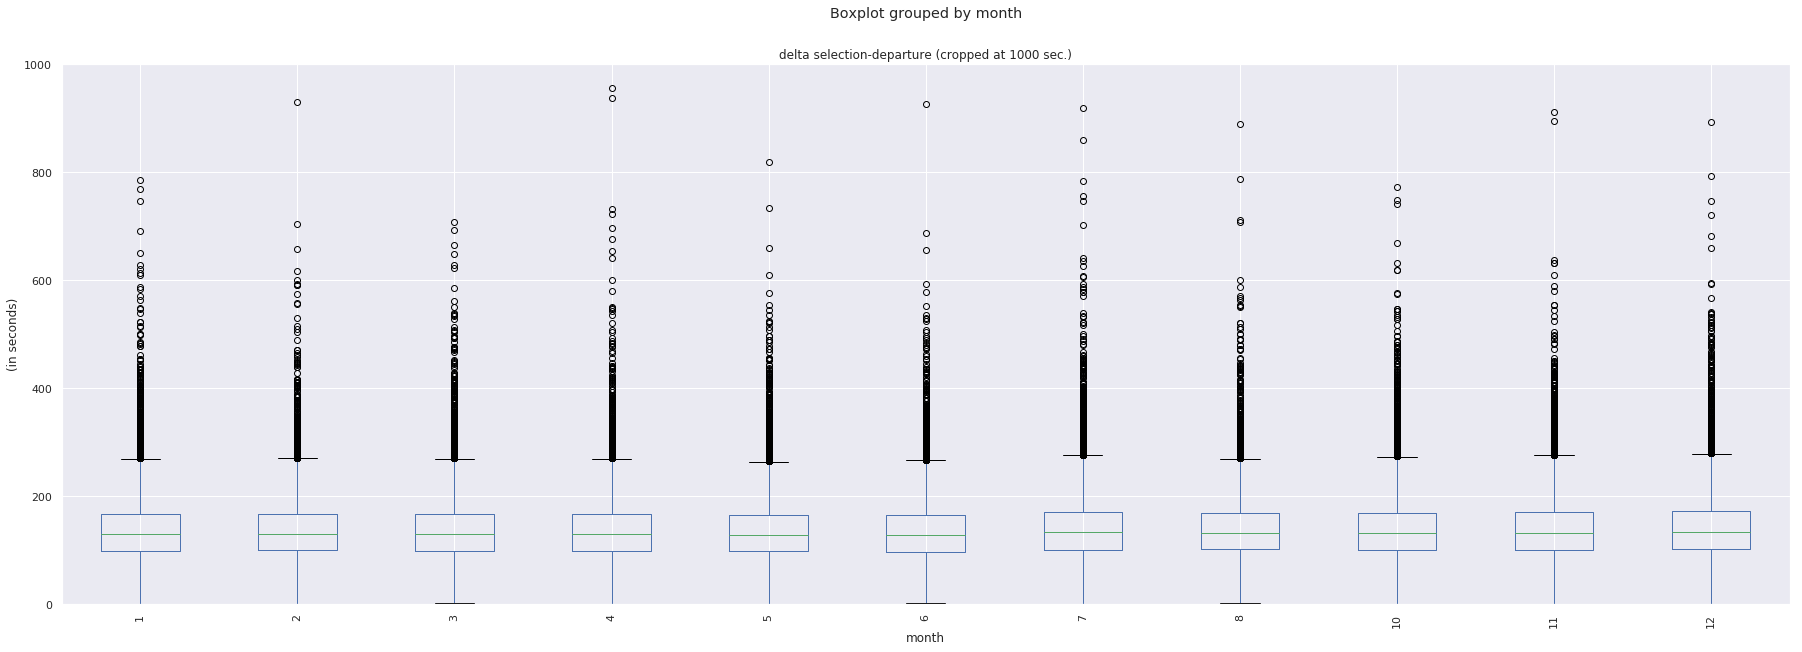

<Figure size 2160x720 with 0 Axes>

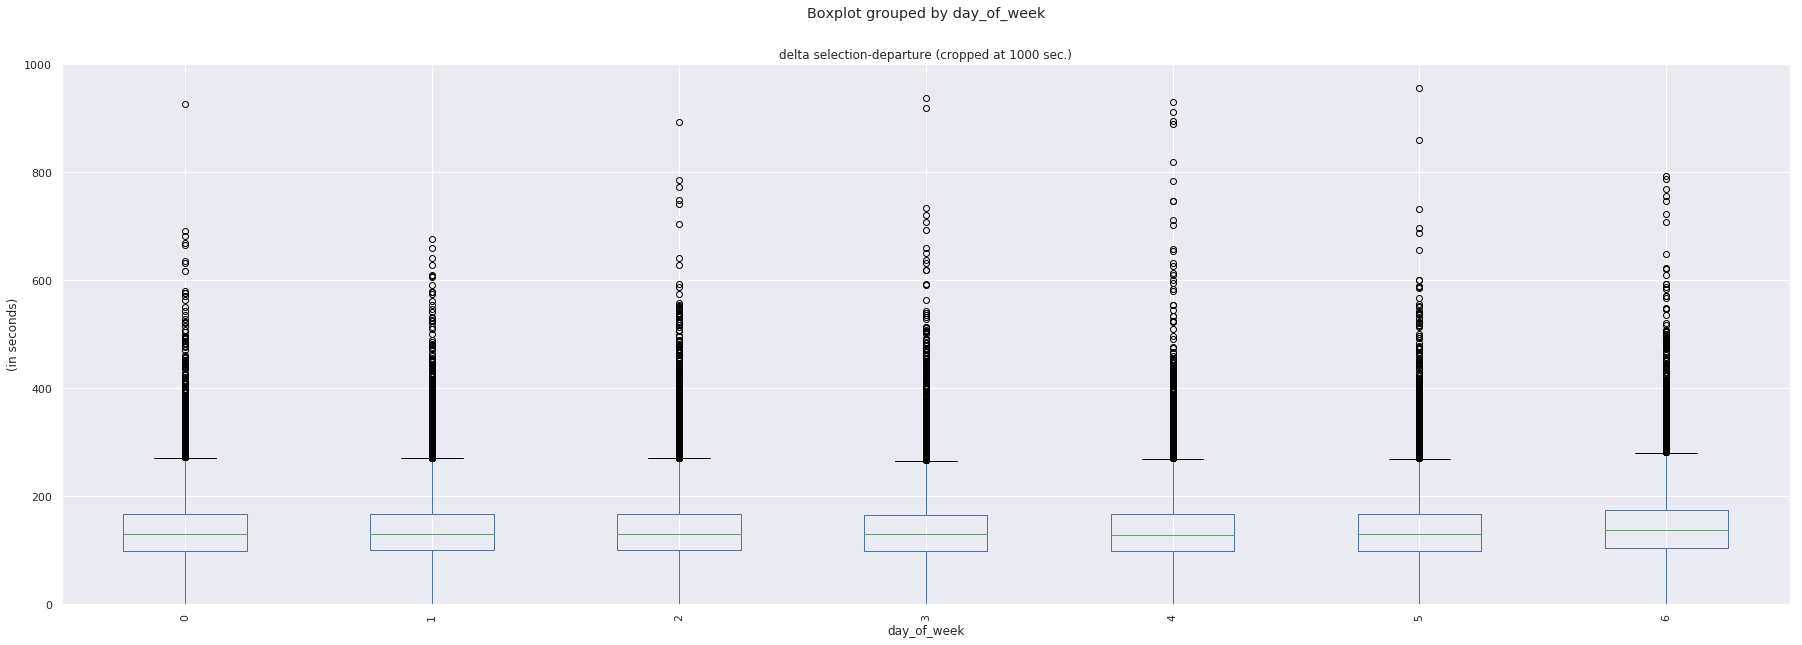

<Figure size 2160x720 with 0 Axes>

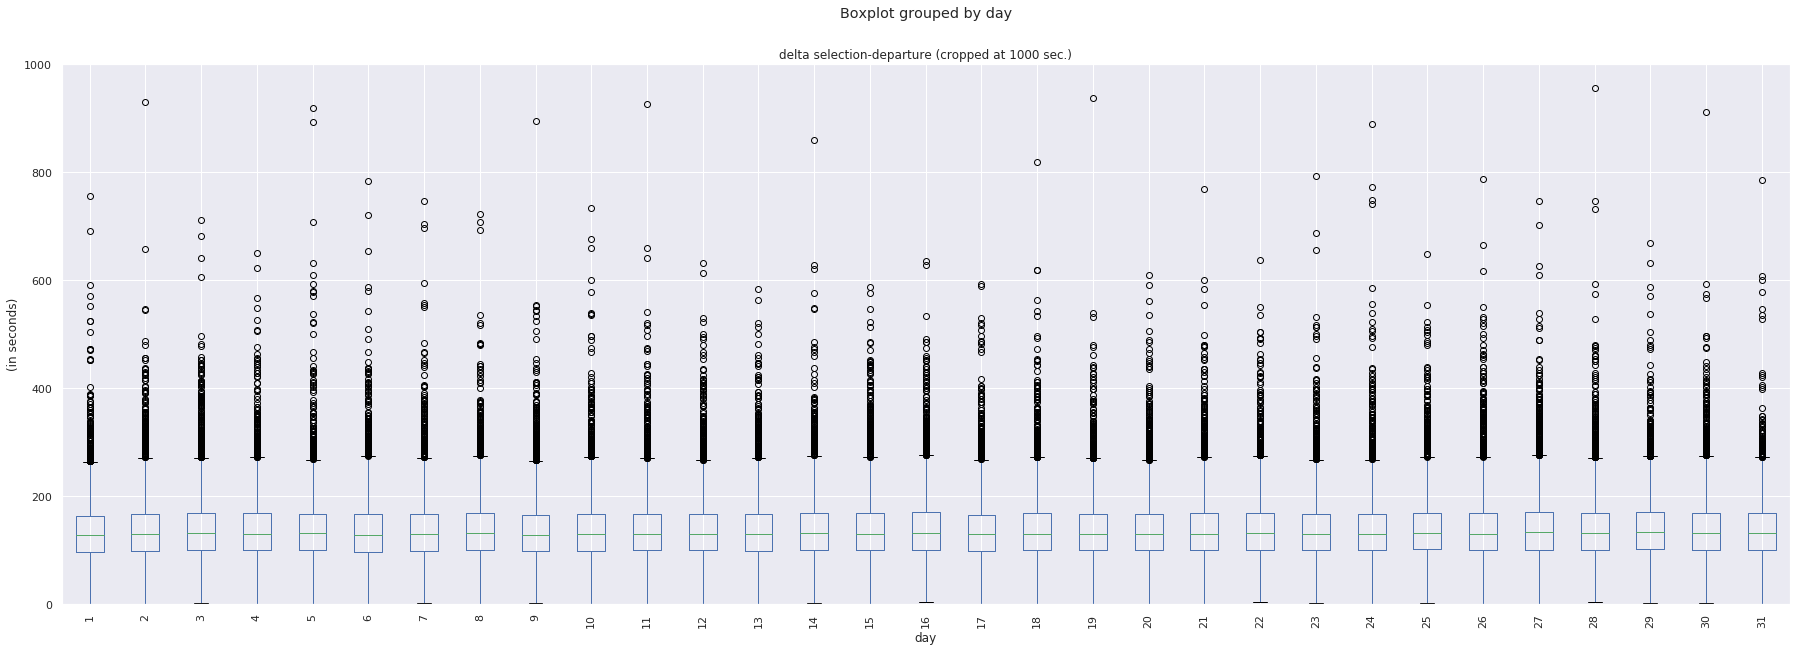

<Figure size 2160x720 with 0 Axes>

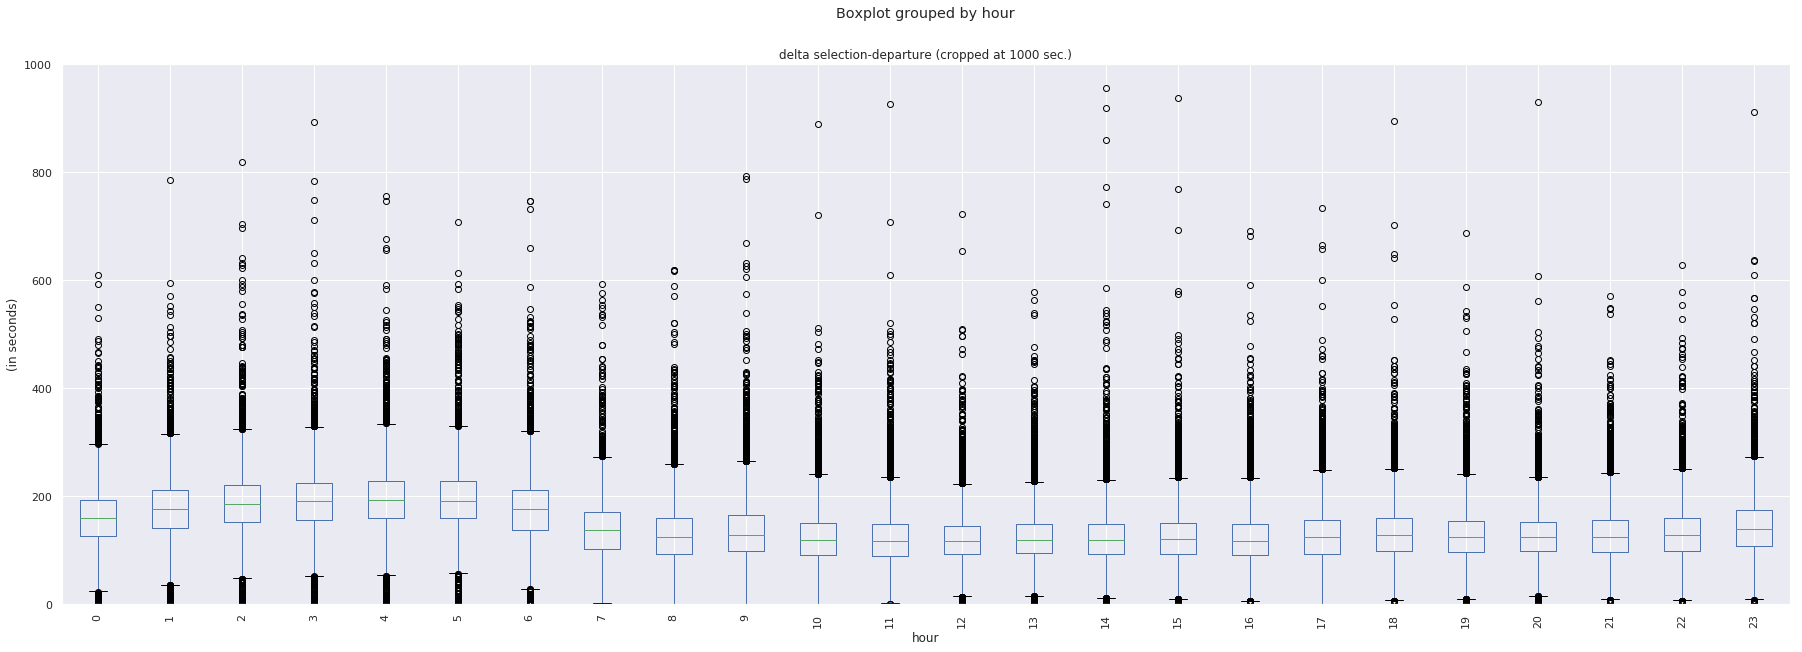

<Figure size 2160x720 with 0 Axes>

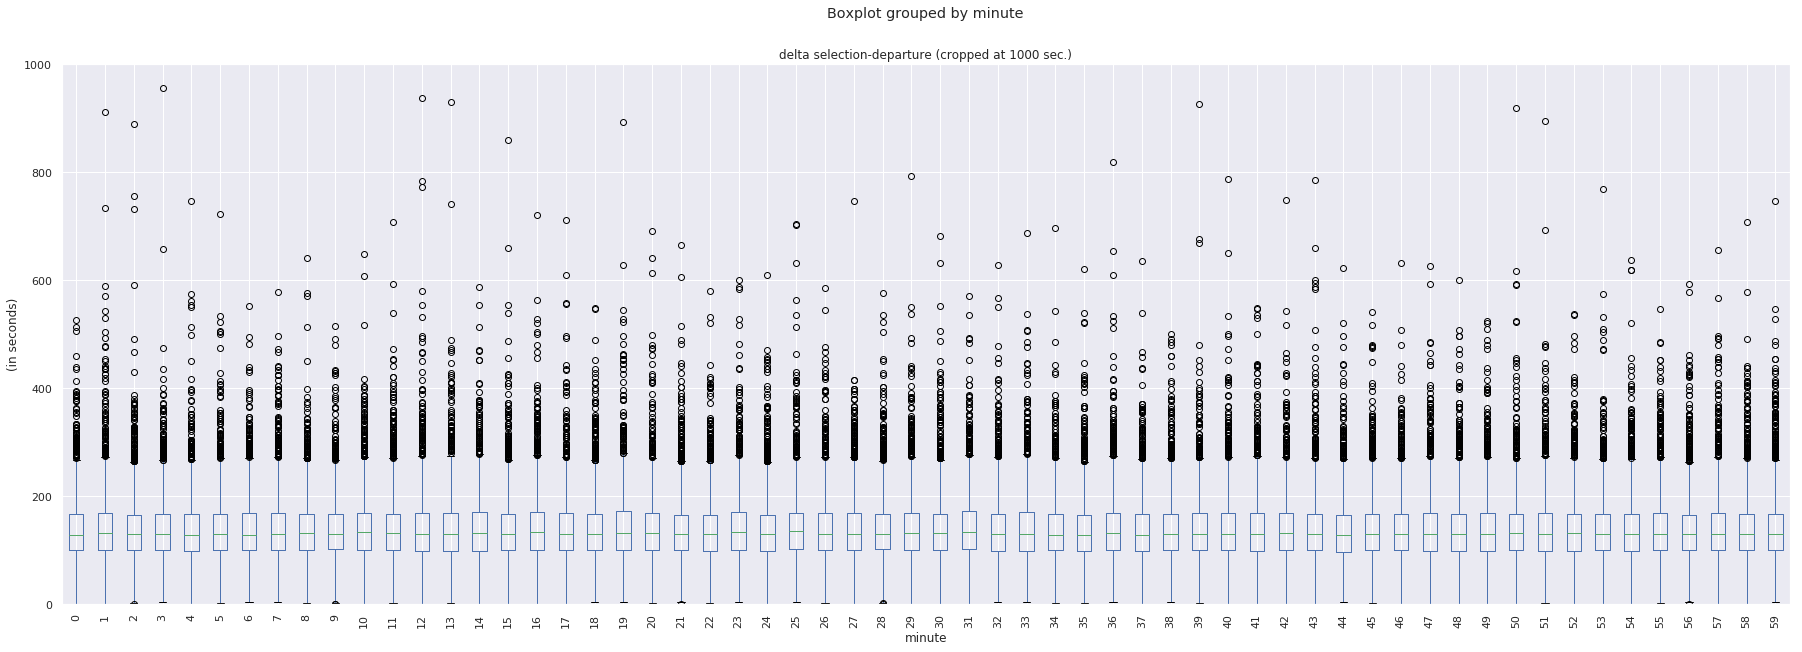

In [39]:
for var in time_vars:
    boxplot(joined, "delta selection-departure", var, upper_clip=1000, save_path="../report/figs/boxplots/time")

### Étude du temps de préparation selon les autres variables catégorielles

<Figure size 2160x720 with 0 Axes>

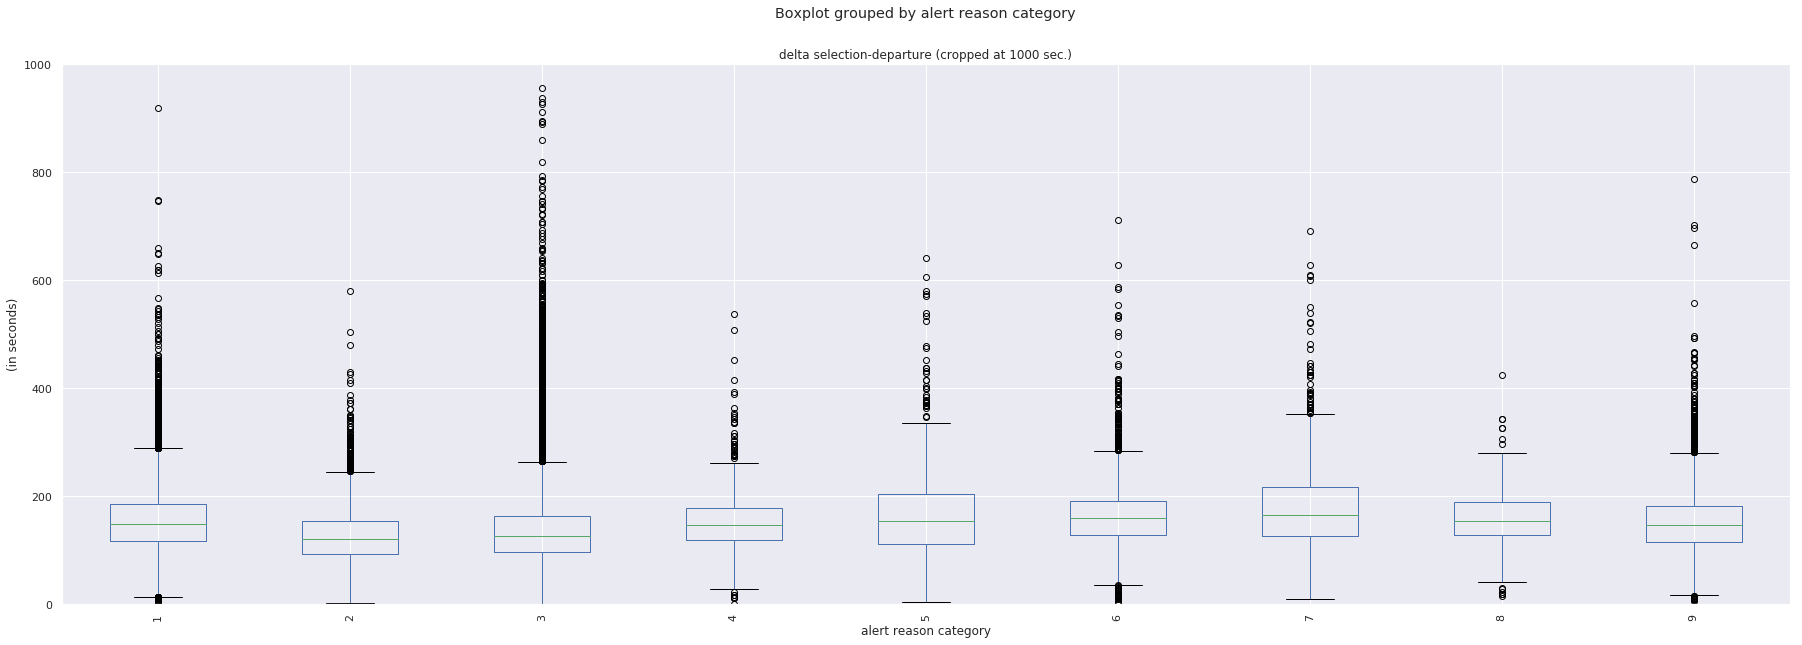

<Figure size 2160x720 with 0 Axes>

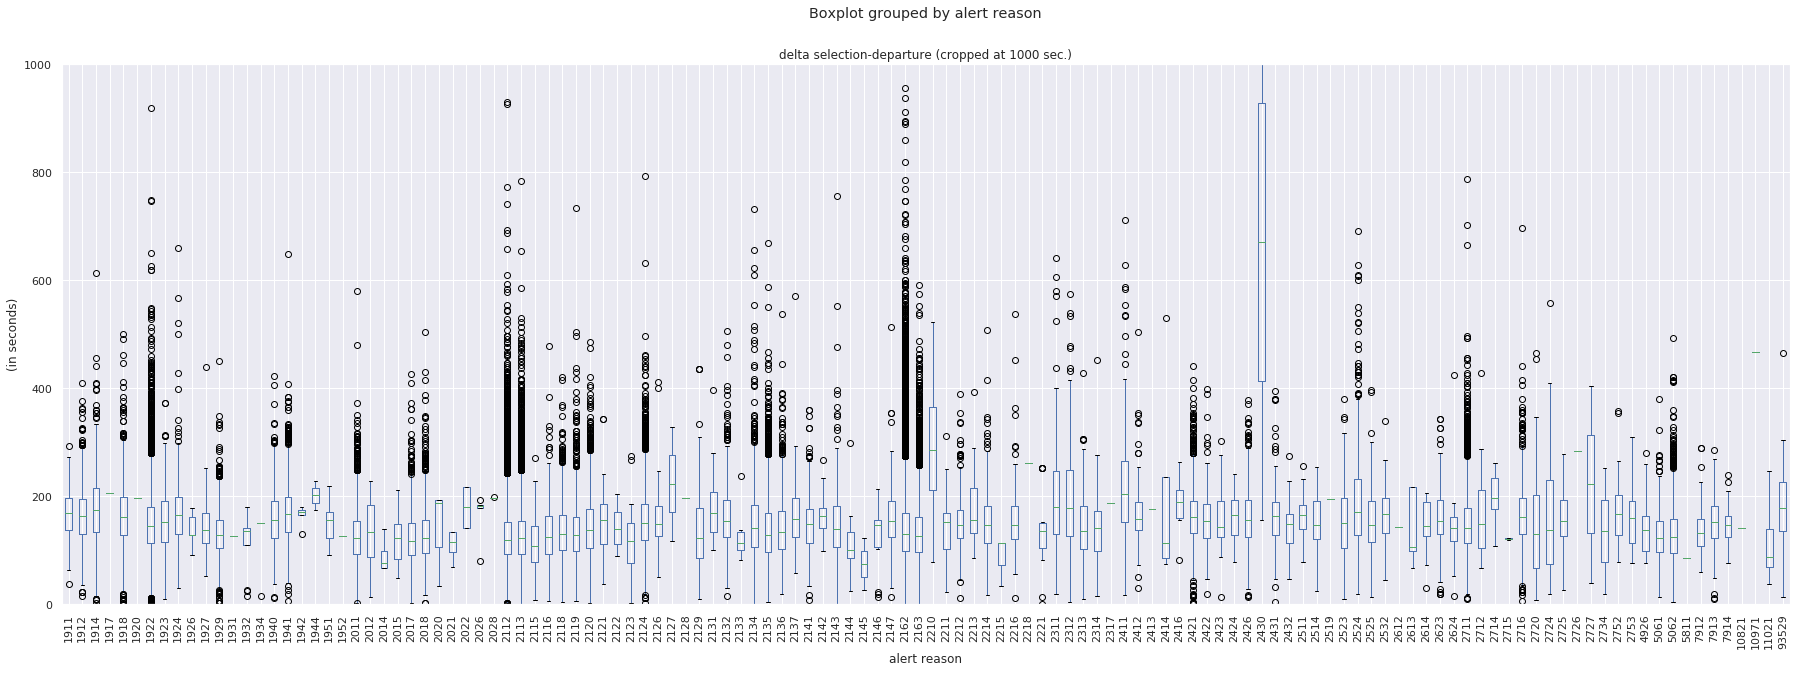

<Figure size 2160x720 with 0 Axes>

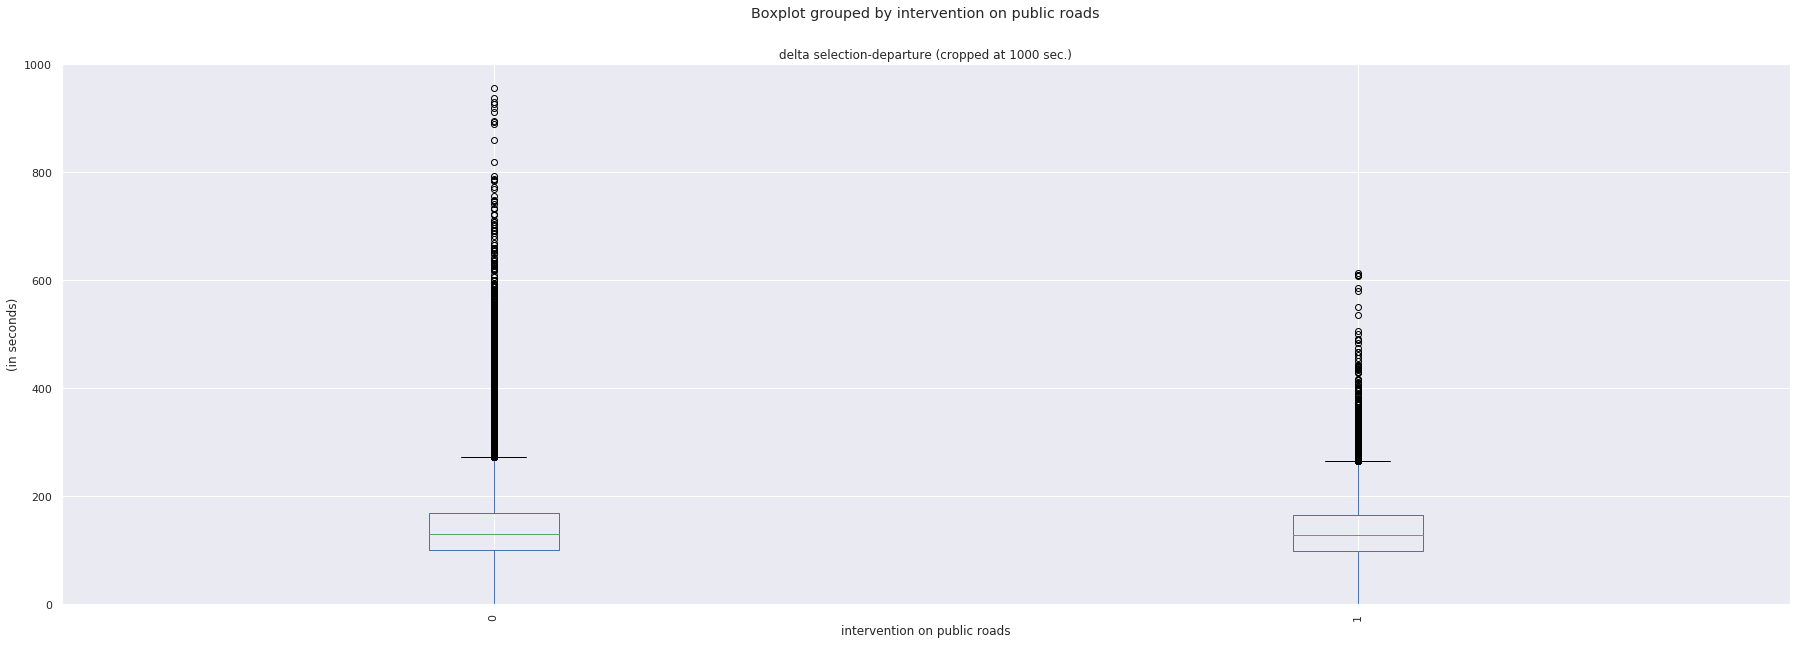

<Figure size 2160x720 with 0 Axes>

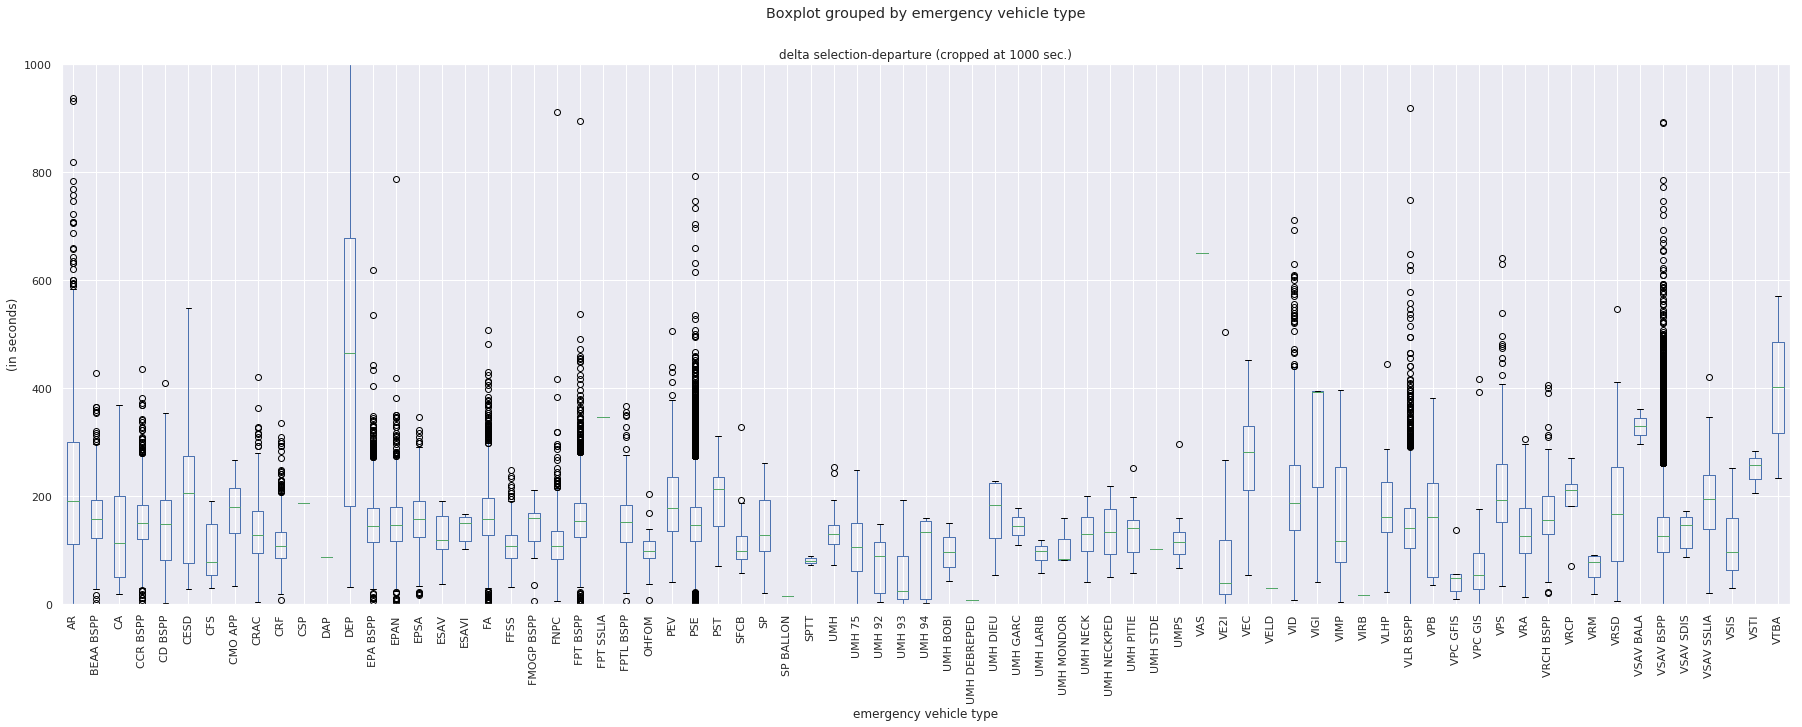

<Figure size 2160x720 with 0 Axes>

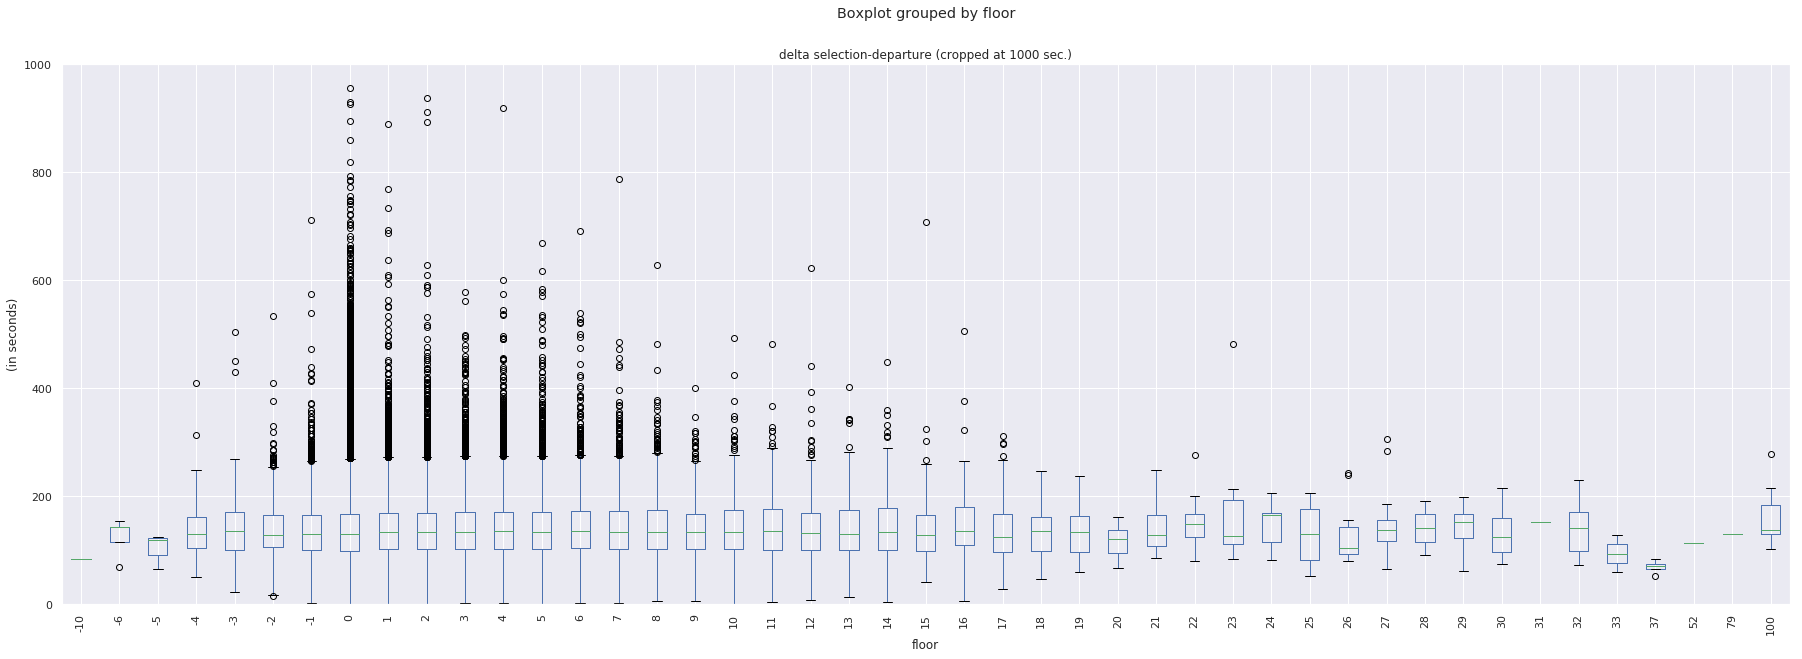

<Figure size 2160x720 with 0 Axes>

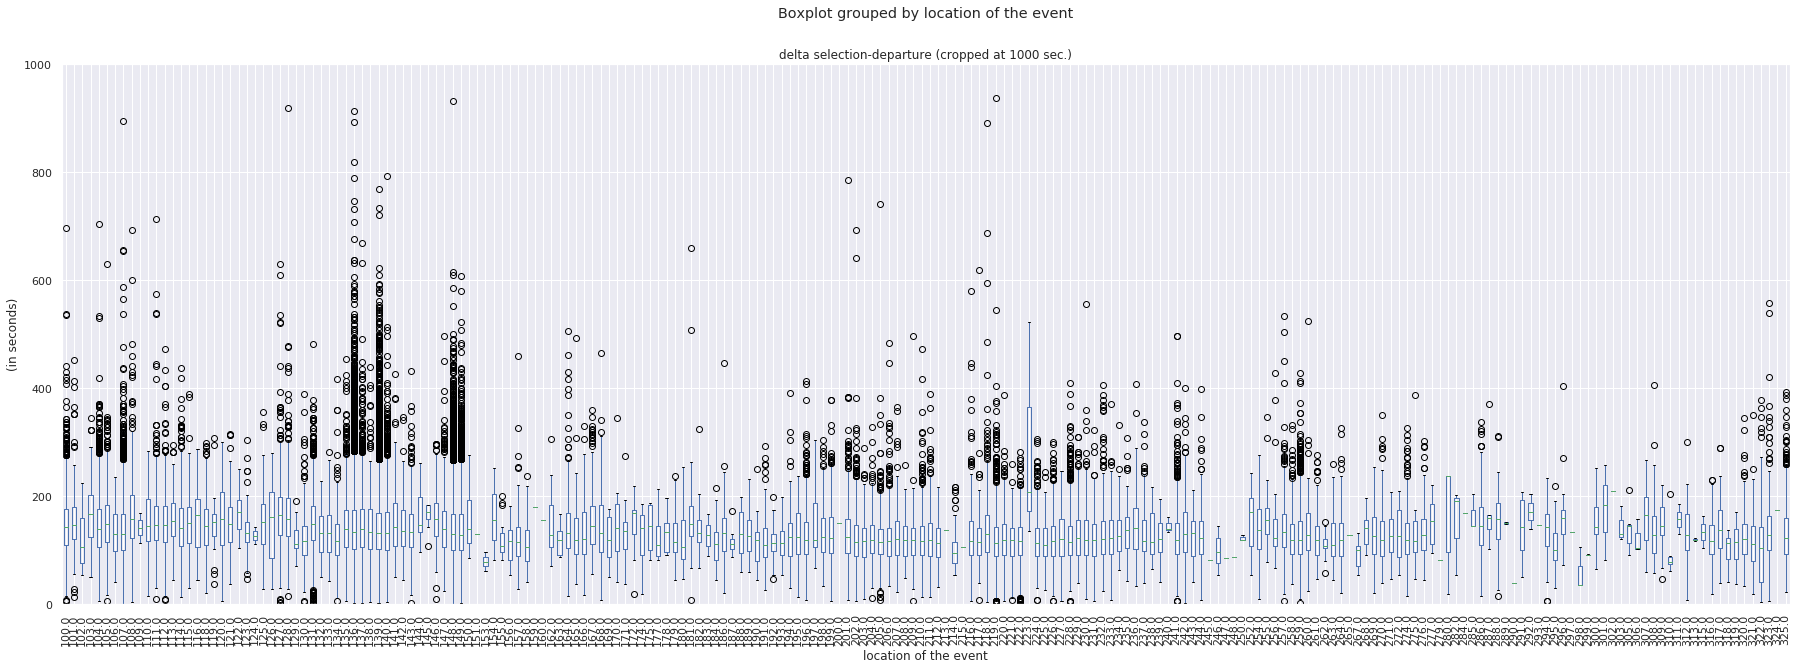

<Figure size 2160x720 with 0 Axes>

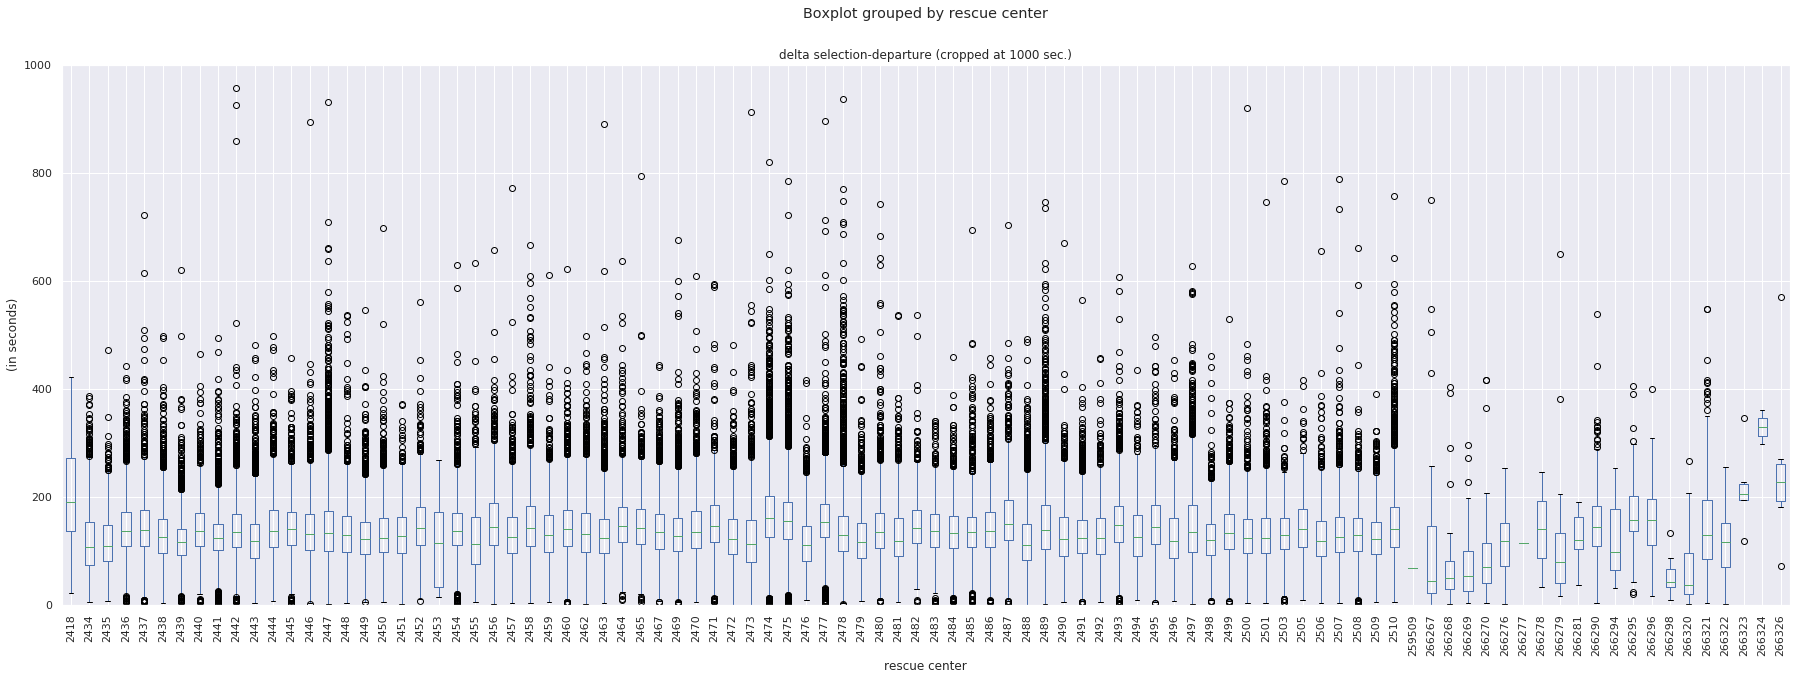

<Figure size 2160x720 with 0 Axes>

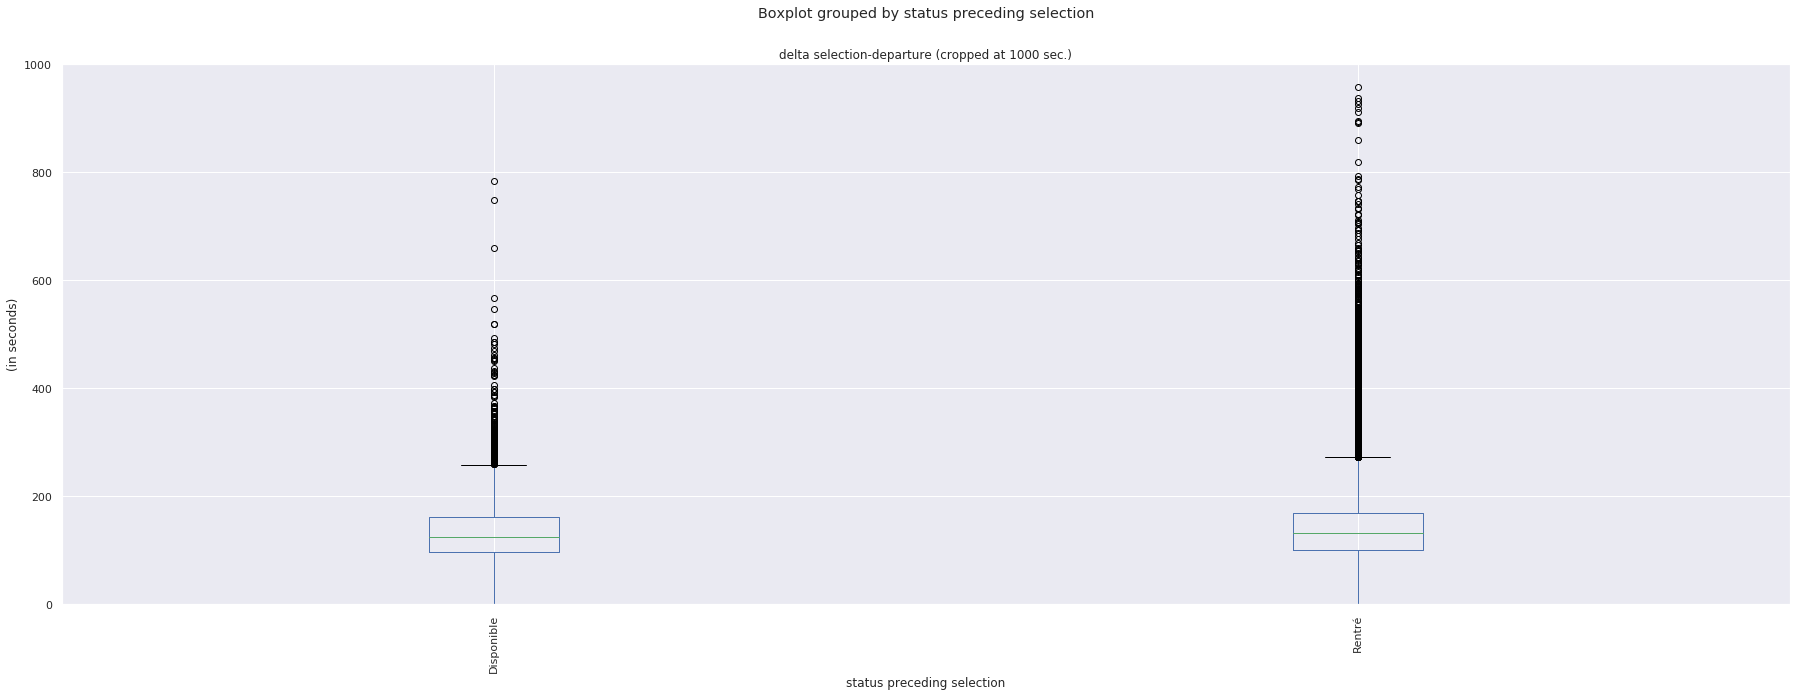

<Figure size 2160x720 with 0 Axes>

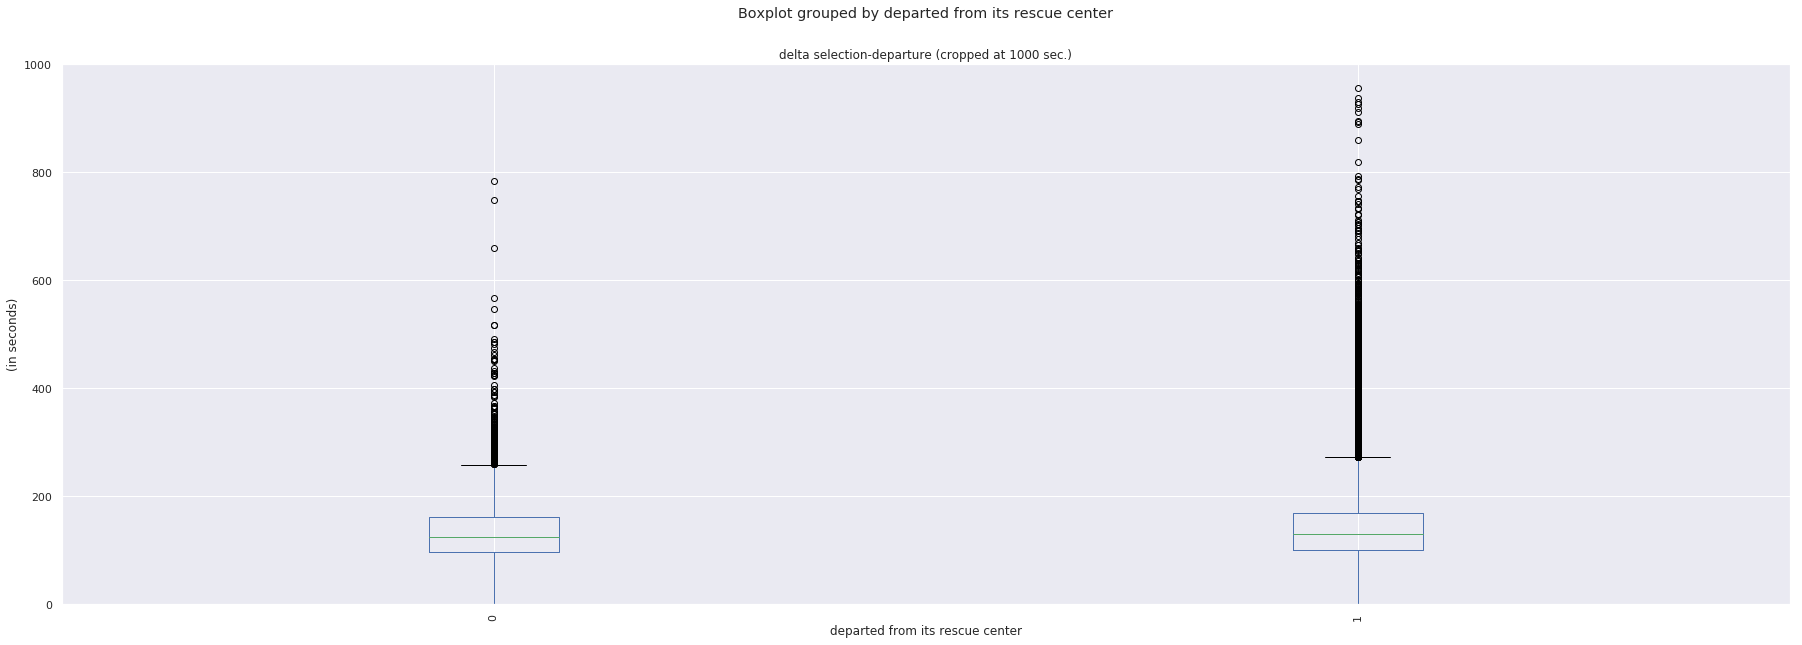

In [40]:
for var in categ_vars:
    boxplot(joined, "delta selection-departure", var, upper_clip=1000, save_path="../report/figs/boxplots/")

### Étude du temps de transit selon les variables temporelles

<Figure size 2160x720 with 0 Axes>

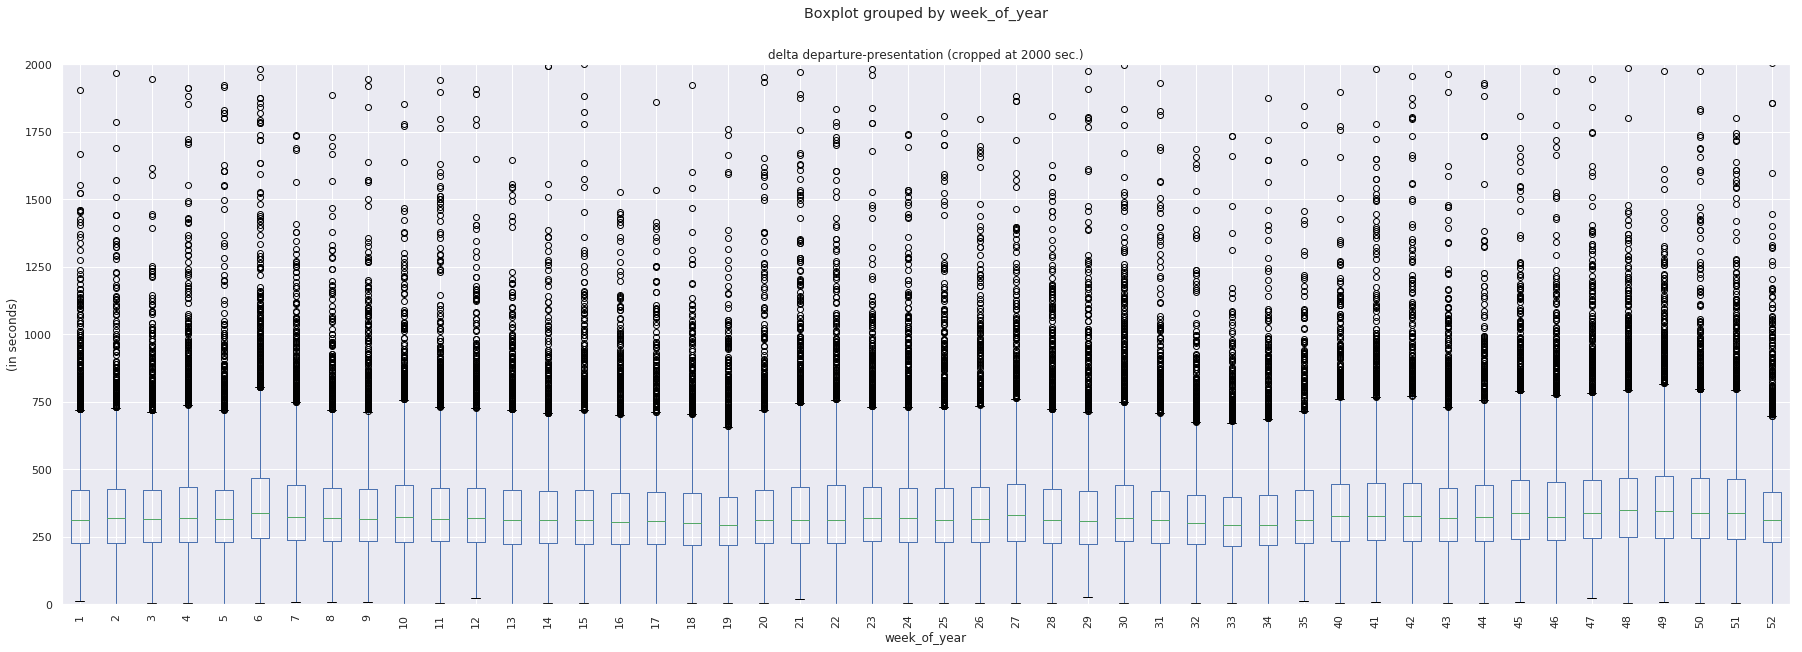

In [ ]:
for var in time_vars:
    boxplot(joined, "delta departure-presentation", var, upper_clip=2000, save_path="../report/figs/boxplots/time")

### Étude du temps de transit selon les autres variables catégorielles

In [ ]:
for var in categ_vars:
    boxplot(joined, "delta departure-presentation", var, upper_clip=2000, save_path="../report/figs/boxplots/")

## Études des trajets 

On s'intéresse au jeu de données supplémentaire données pour les données GPS des véhicules.

In [ ]:
x_train_add = pd.read_csv(os.path.join(TRAINING_DATA, 'x_train_additional_file.csv'), sep=',')
x_train_add = x_train_add.set_index(INDEX_COLUMN)
x_train_add = x_train_add.dropna()
x_train_add.head()

In [ ]:
features_GPS = [
    'longitude intervention',
    'latitude intervention',
    'longitude before departure',
    'latitude before departure',
    'GPS tracks departure-presentation',
    'GPS tracks datetime departure-presentation',
    'OSRM response',
    'OSRM estimated distance',
    'OSRM estimated duration',
    'OSRM estimate from last observed GPS position',
    'OSRM estimated distance from last observed GPS position',
    'OSRM estimated duration from last observed GPS position',
    'time elapsed between selection and last observed GPS position',
    'updated OSRM estimated duration'
]

data_traffic = x_train.join(x_train_add, on=INDEX_COLUMN, how="inner")[features_GPS].join(y_train)
data_traffic

On réalise des estimations relativement simples des vitesse données par les itinéraires et des vitesses observées.

In [ ]:
estimated_mean_speed = data_traffic["OSRM estimated distance"] / data_traffic["OSRM estimated duration"] * 3.6

observed_mean_speed = (data_traffic["OSRM estimated distance"] - data_traffic["OSRM estimated distance from last observed GPS position"]) / data_traffic["time elapsed between selection and last observed GPS position"]
observed_mean_speed = observed_mean_speed[observed_mean_speed > 0]
observed_mean_speed = observed_mean_speed[observed_mean_speed < 20]
observed_mean_speed *= 3.6

plt.title("Comparing speeds (using OSRM estimation and observed data)")

plt.hist(estimated_mean_speed, alpha=0.6, bins=100)
plt.hist(observed_mean_speed, alpha=0.6, bins=100)
plt.xlabel("Speed (in km.s⁻¹)")
plt.legend(["Estimated speed (via OSRM)", "Observed speed (using OSRM and data)"])
plt.xlim(0, 70)

On remarque que les vitesses estimées par OSRM sont bien au deça des vitesses réelles enregistrées.

## Comparaison des trajets

In [ ]:
def route_from_itinary(itinary):
    route = []
    for step in itinary["routes"][0]["legs"][0]["steps"]:
        route.append(step["intersections"][0]["location"])
    return route

def routes_from_example(example):
    observed_route = []
    for t in  example["GPS tracks departure-presentation"].split(";"):
        lon, lat = t.split(",")
        observed_route.append([float(lon), float(lat)])

    lon_start = example["longitude before departure"]
    lat_start = example["latitude before departure"]

    lon_end = example["longitude intervention"]
    lat_end = example["latitude intervention"]

    last_lon_obs, last_lat_obs = observed_route[-1]

    proposed_route = route_from_itinary(get_itinary(lon_start, lat_start, lon_end, lat_end, with_details=True))
    estimated_end_route = route_from_itinary(get_itinary(last_lon_obs, last_lat_obs, lon_end, lat_end, with_details=True))
    
    points = lon_start, lat_start, lon_end, lat_end
    return observed_route, proposed_route, estimated_end_route, points

In [ ]:
def geojson_line(coordinates):
    gj = {
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'LineString',
            'coordinates': coordinates
        }
    }
    return gj

def geojson_point(lat, lon):
    gj = {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "Point",
            "coordinates": [lat, lon]
        }
    }
    return gj

style_observed = {'color': "green", 'opacity':0.6, 'weight':5, 'fillOpacity':0.1}
style_proposed = {'color': "blue", 'opacity':0.6, 'weight':5, 'fillOpacity':0.1}
style_estimated_end = {'color': "red", 'opacity':0.6, 'weight':5, 'fillOpacity':0.1}

In [ ]:
data_traffic.loc[5103635]

On affiche certains trajets réalisés et ceux de leurs itinéraires recommandés par OSRM.

Apparaissent:
 
  - en vert, les début de trajets observé
  - en rouge, les prédictions de fin de trajets à partir de la dernière prédictions
  - en blue, le trajet recommandé de l'itinéraire.

In [ ]:
m = ClickableMap()

for i in np.random.choice(65760, 40, replace=False):
    observed_route, proposed_route, estimated_end_route, points = routes_from_example(example = data_traffic.iloc[i])

    lon_start, lat_start, lon_end, lat_end = points

    # Affichage en différente couleur des trajets réels et des itinéraires recommandés
    m.add_geojson(geojson_line(proposed_route), style_proposed)
    m.add_geojson(geojson_line(observed_route), style_observed)
    m.add_geojson(geojson_line(estimated_end_route), style_estimated_end)

    m.add_geojson(geojson_point(lon_start, lat_start))
    m.add_geojson(geojson_point(lon_end, lat_end))

m.zoom = 11
m

Les trajets empruntés se rapprochent le plus souvent des trajets des itinéraires recommandés par d'OSRM.